In [3]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
from collections import defaultdict
import json

/Users/dankur/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### TODO: Load in datasets to see how to sparsify v for 
- One coding dataset
- One wiki dataset
- One general internet dataset
- One dialogue/assistant dataset

### TODO: Report the percentage of logits needed for cumsum to be 80, 90, 95, 99%
- if you keep the top n% for n in 1, 5, 10, 20, what are their percentages
### TODO: Run metrics across different sequence lengths
- Find max seq length and use prefixes of it
  -  also filter out sequences under a certain length
- report metrics at intermediate sequence lengths
  - ex). on __ sequences, these are the metrics for __ sequence length
- Track worst case (sparsity) - when the data is not sparse b/c all the logits are close
  - more evenly distrubuted logits


In [48]:
class DatasetTypes(Enum):
    WIKI = ('wikitext', 'wikitext-2-raw-v1')
    INTERNET = 'Skylion007/openwebtext'
    CODE = 'bigcode/starcoderdata'
    ASSISTANT = 'HuggingFaceH4/ultrachat_200k'

def get_dataset (dataset_type: DatasetTypes):
    if dataset_type == DatasetTypes.WIKI:
        return load_dataset(dataset_type.value[0], dataset_type.value[1], streaming=True)
    return load_dataset(dataset_type.value, streaming=True)


In [49]:
dataset = get_dataset(DatasetTypes.WIKI)

In [50]:
# Load tokenizer and model
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)

In [112]:
num_of_samples = 10

In [123]:
stream = iter(dataset['train'])

In [124]:
min_seq_len = 500
top_ks = [1, 5, 10, 20]
metric_cumsums = [80, 90, 95, 99]
samples_metrics = list()
cumsum_metrics = [[{'avg': torch.zeros((min_seq_len)), 'worst': torch.ones((min_seq_len))} for _ in range(model.config.n_head)] for _ in range(model.config.n_layer)]


In [125]:
# Encode input and create tensors
for i in range(num_of_samples):
    input_text = next(stream)['text']
    inputs = tokenizer(input_text, return_tensors="pt")
    sequence_length = inputs.input_ids.shape[1]

    while sequence_length <= min_seq_len:
        inputs = tokenizer(input_text, return_tensors="pt")
        input_text = next(stream)['text']
        sequence_length = inputs.input_ids.shape[1]

    # cap length of input to min sequence length tokens
    inputs_sliced = {
        'input_ids': inputs.input_ids[:,:min_seq_len],
        'attention_mask': inputs.attention_mask[:,:min_seq_len]
    }
 
    sequence_length = inputs_sliced['input_ids'].shape[1]


    metrics = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0.0))))
    
    # Run the model
    with torch.no_grad():
        outputs = model(**inputs_sliced)

    # Get the attentions
    attentions = outputs.attentions  # Tuple of tensors: one for each layer


    for l, layer_attention in enumerate(attentions):
        for h in range(model.config.n_head): 
            att = layer_attention[0, h, -1, :].sort().values
            reverse_att = att.flip(0)
            total_prob = att.cumsum(0)
            reverse_total_prob = reverse_att.cumsum(0)

            cumsum_metrics[l][h]['avg'] += reverse_total_prob
            cumsum_metrics[l][h]['worst'] = torch.min(cumsum_metrics[l][h]['worst'], reverse_total_prob)

            for k, total_sum in zip(top_ks, metric_cumsums):
                k_percentile, desired_sum = k / 100, total_sum / 100
                
                min_elements = torch.nonzero(reverse_total_prob > desired_sum)[0]

                top_percentile_prob = total_prob[-int(k_percentile * sequence_length)]

                prev_precentile = metrics[l][h]["top_percentile_prob"]
                prev_total_sum = metrics[l][h][ "min_logits_for_cumsum"]
                prev_precentile[f"{k}%"] = 1 - top_percentile_prob.item()
                prev_total_sum[f"{total_sum}%"] = 1 + min_elements.item()

    samples_metrics.append(metrics) 

In [126]:
print(json.dumps(samples_metrics, indent=4))

[
    {
        "0": {
            "0": {
                "top_percentile_prob": {
                    "1%": 0.14737510681152344,
                    "5%": 0.45787233114242554,
                    "10%": 0.6318183243274689,
                    "20%": 0.7844345420598984
                },
                "min_logits_for_cumsum": {
                    "80%": 107,
                    "90%": 188,
                    "95%": 266,
                    "99%": 401
                }
            },
            "1": {
                "top_percentile_prob": {
                    "1%": 0.9681888520717621,
                    "5%": 0.9976724002044648,
                    "10%": 0.9988274776842445,
                    "20%": 0.9995534913614392
                },
                "min_logits_for_cumsum": {
                    "80%": 2,
                    "90%": 2,
                    "95%": 3,
                    "99%": 9
                }
            },
            "2": {
                "top_percentil

/var/folders/vx/l144l7157lg0ywjmtn_9vt2w0000gn/T/ipykernel_1814/2692087021.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


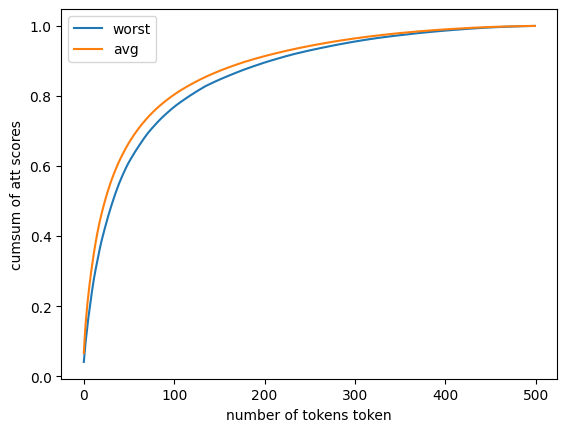

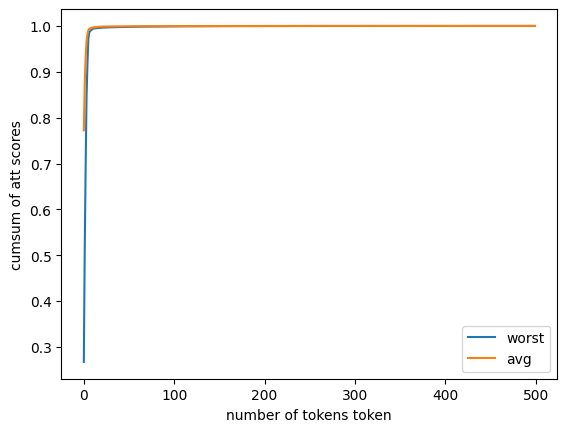

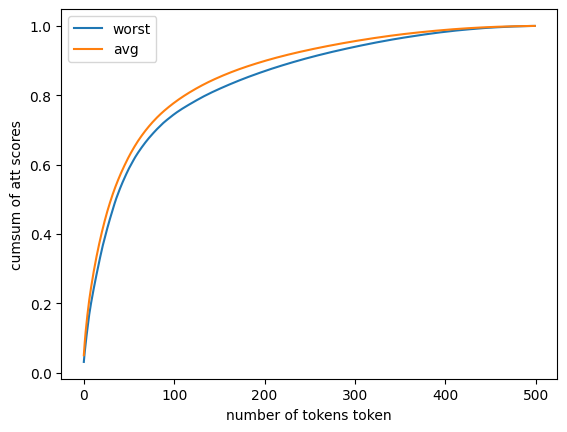

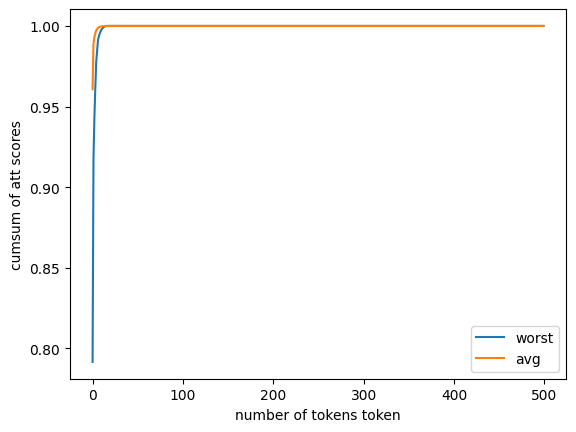

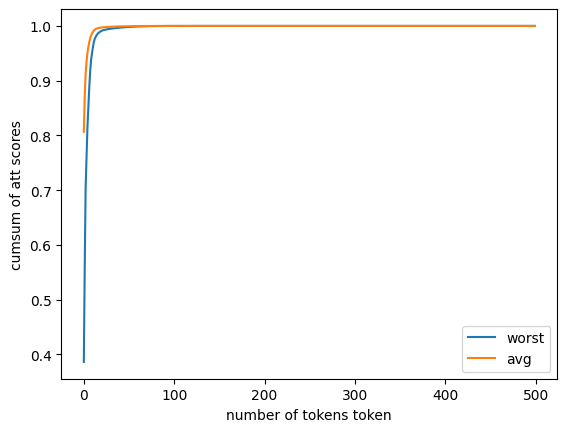

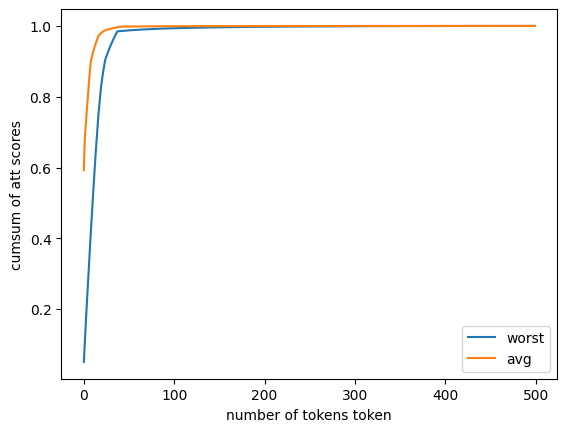

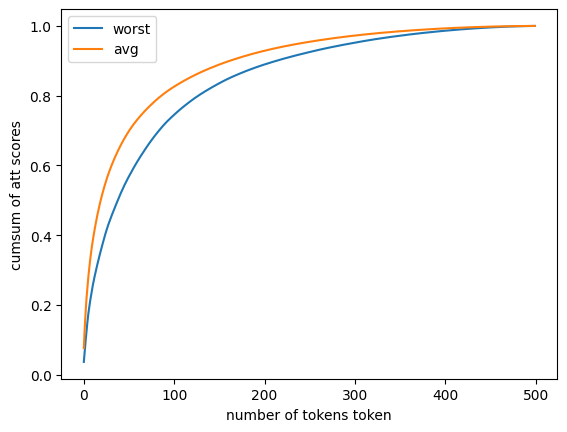

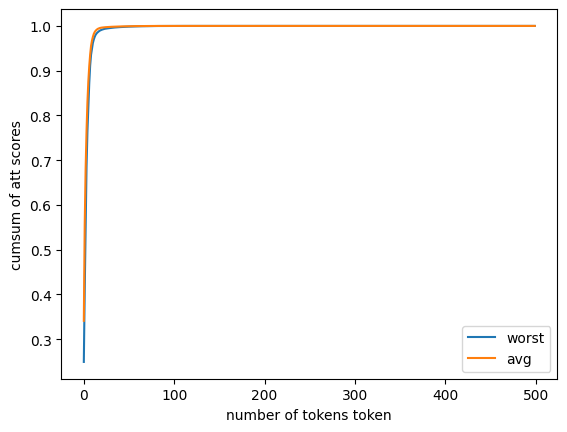

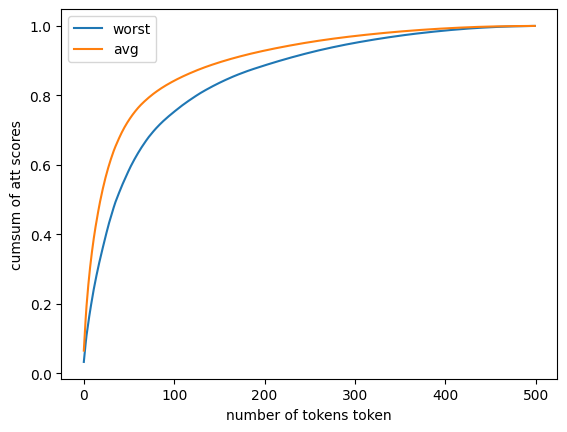

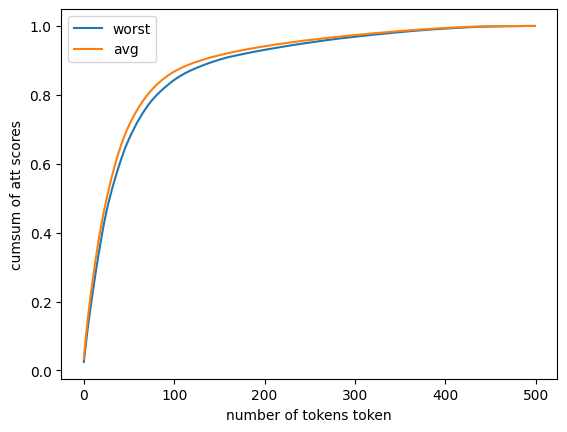

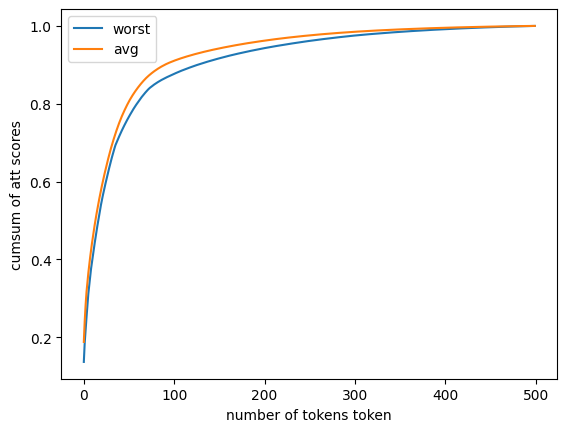

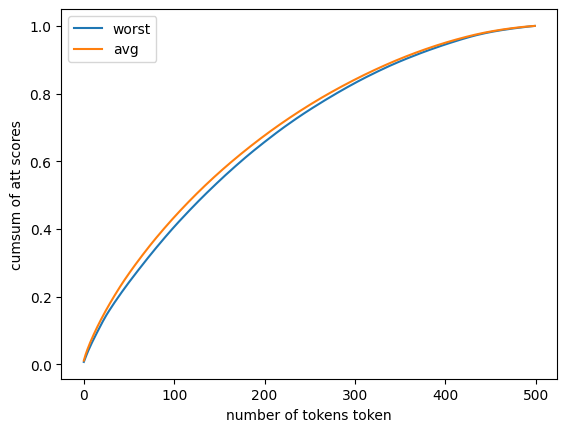

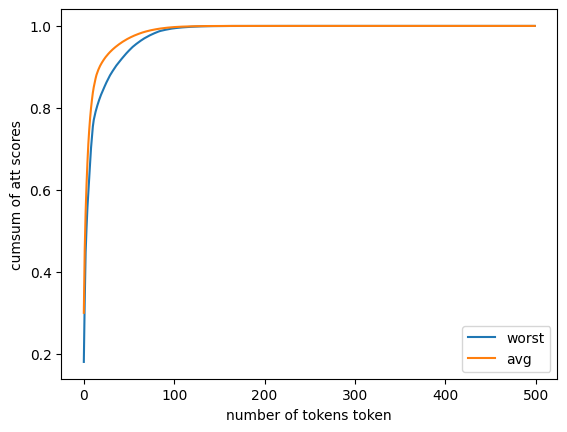

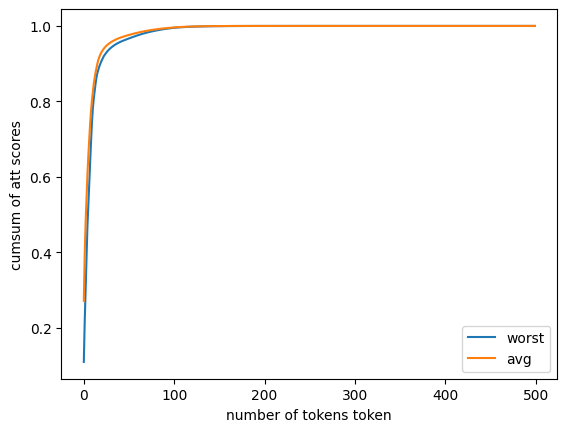

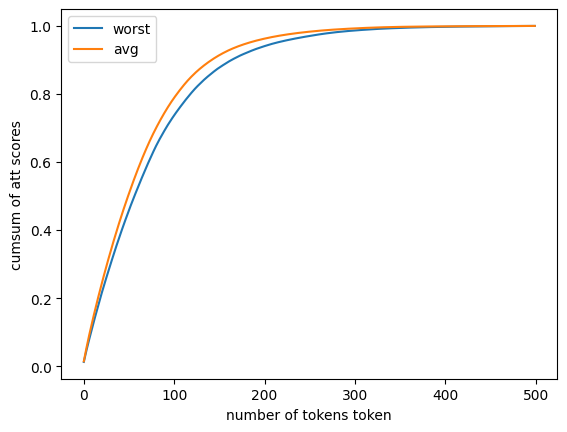

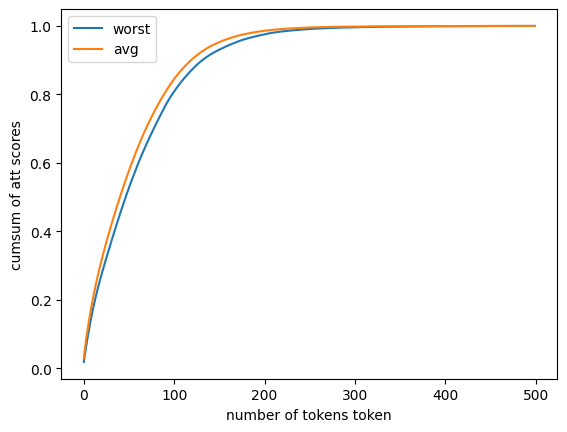

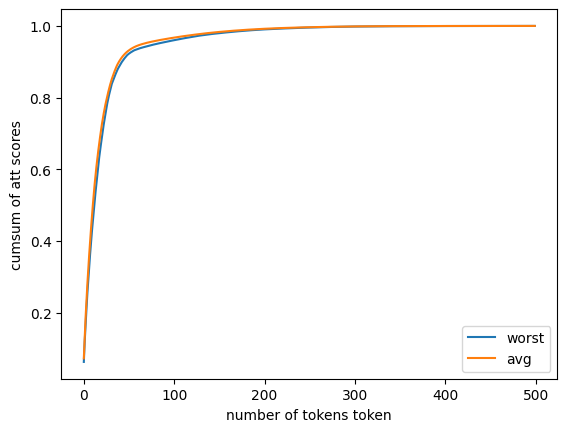

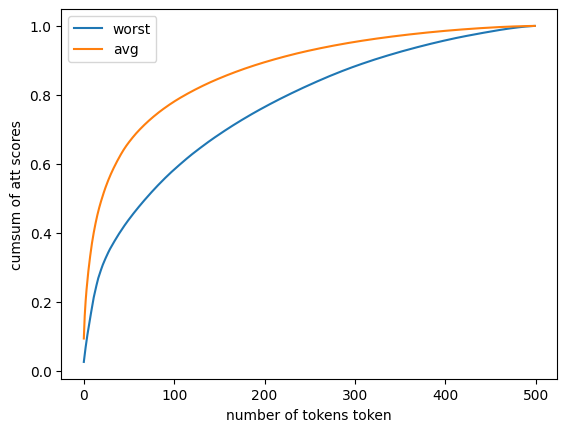

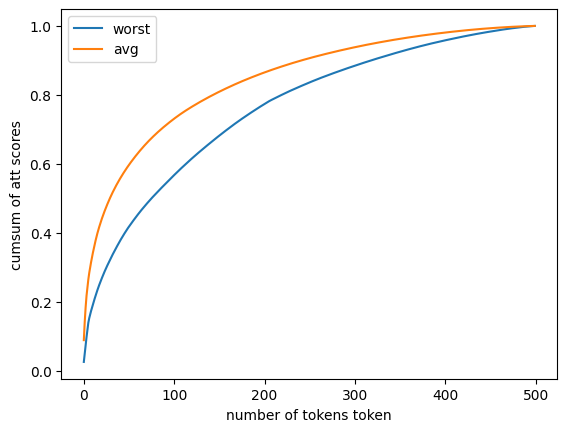

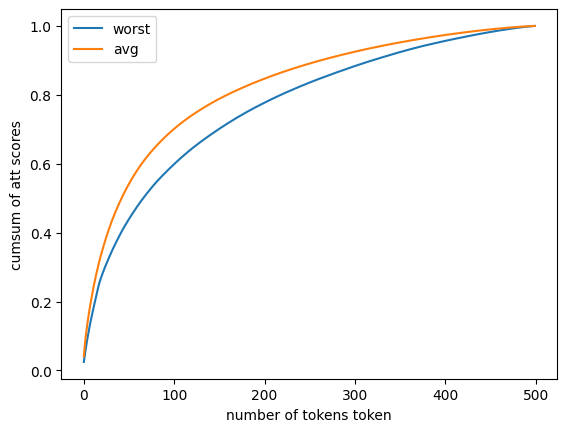

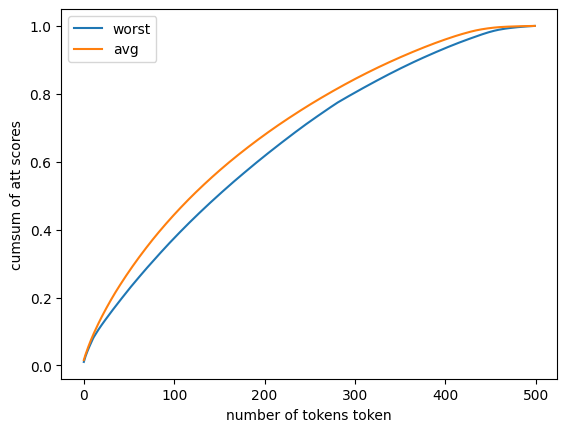

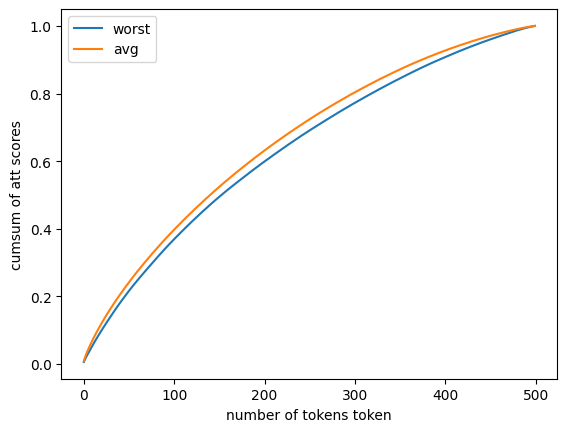

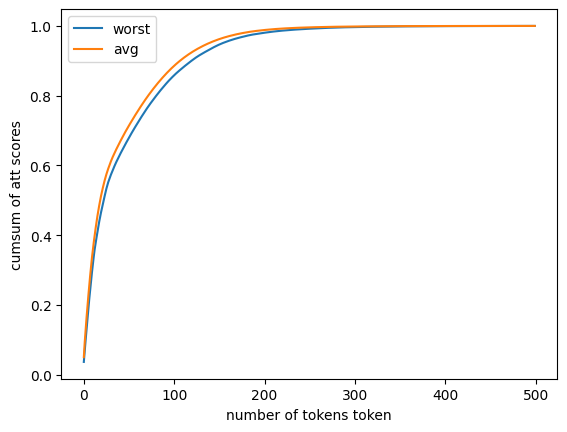

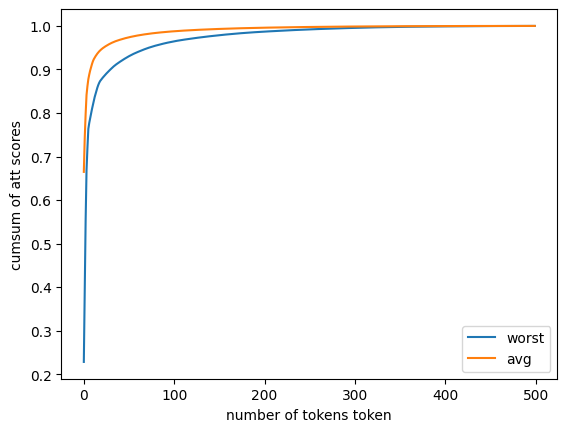

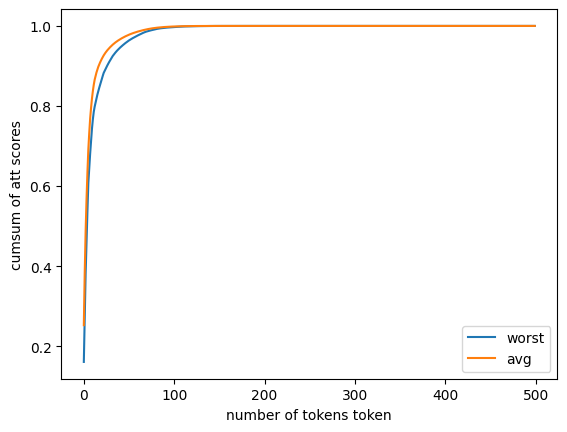

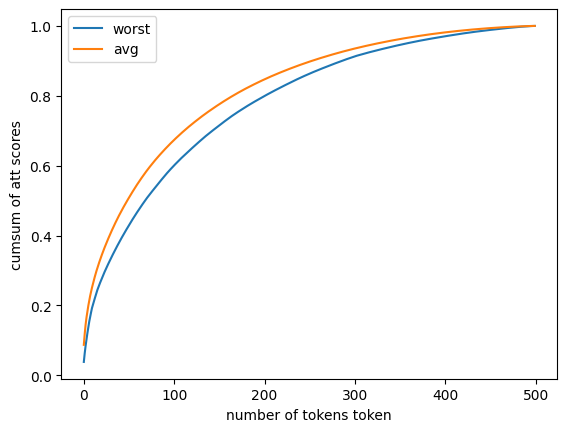

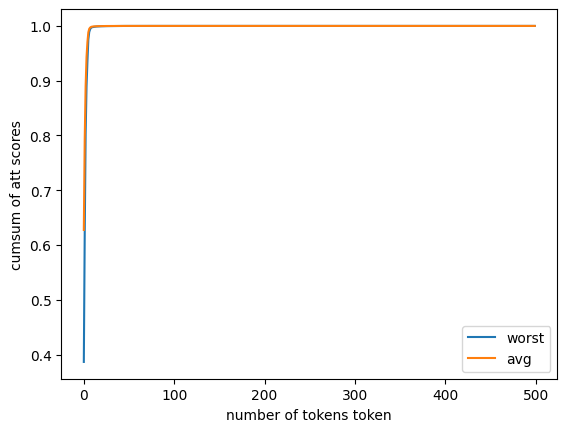

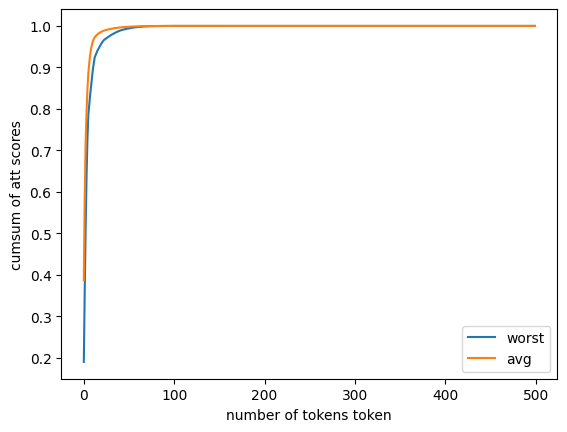

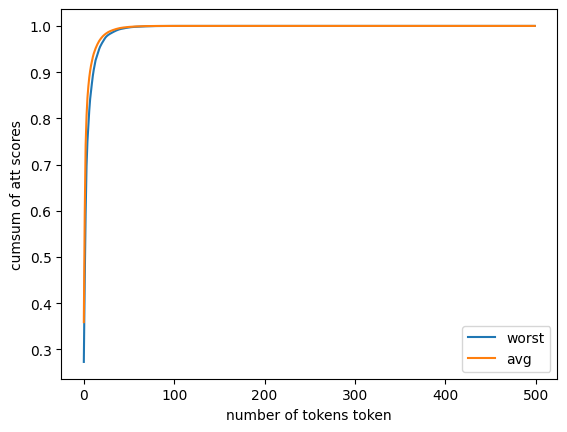

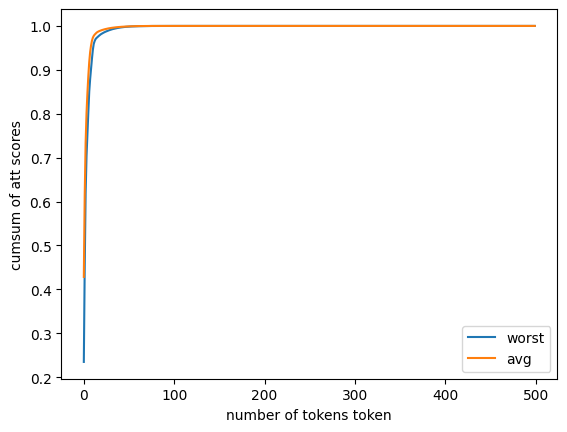

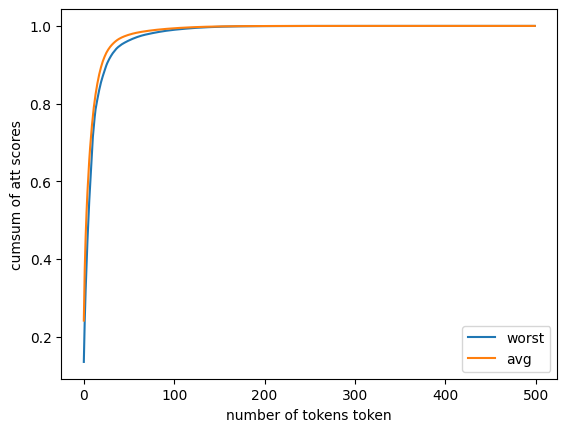

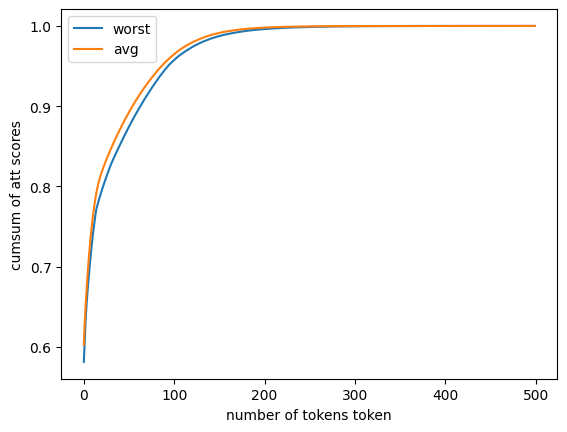

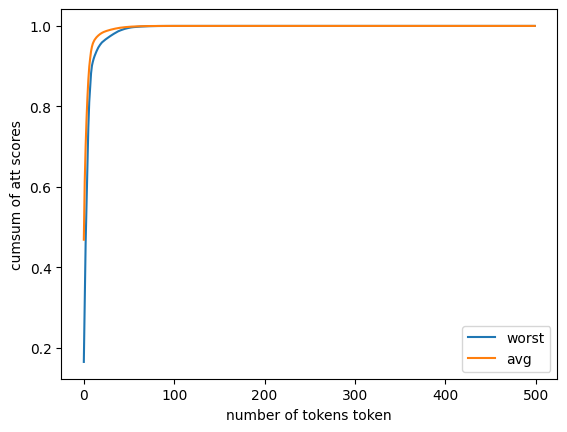

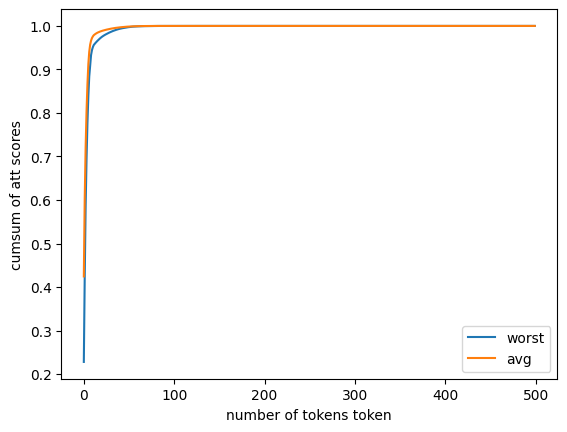

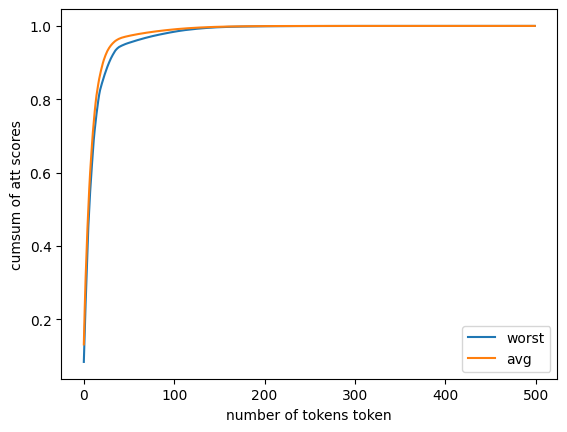

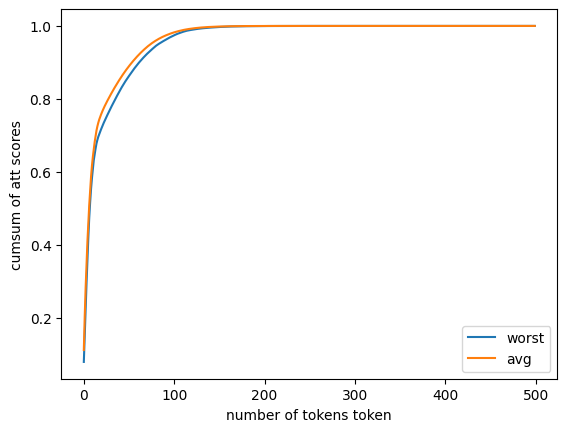

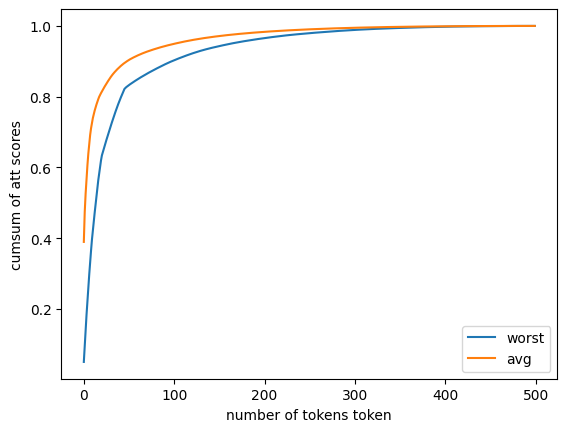

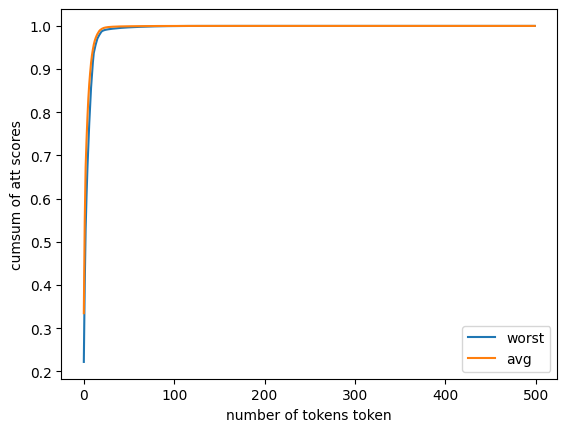

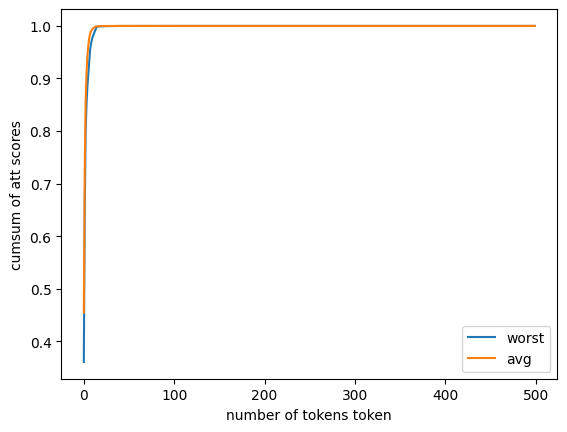

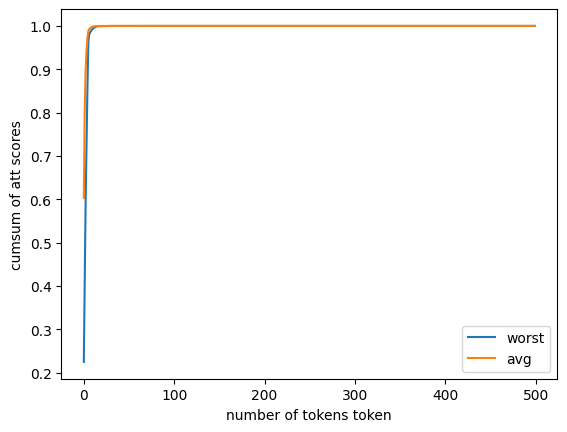

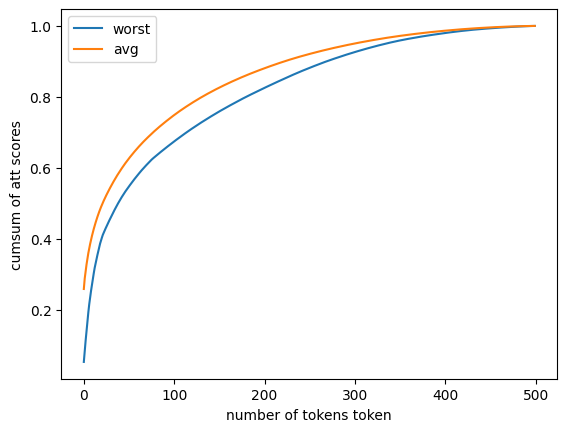

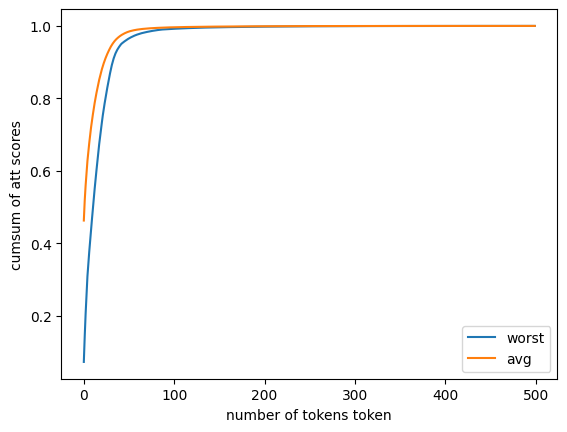

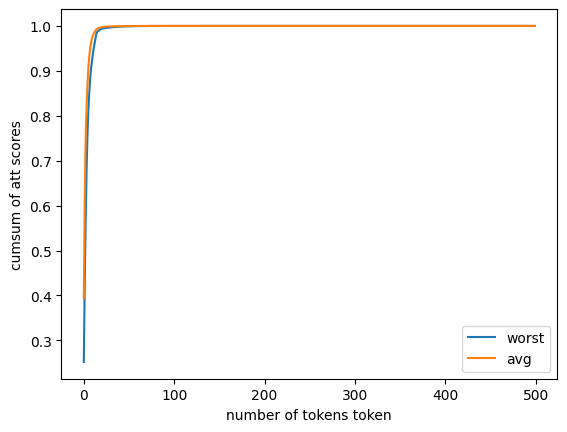

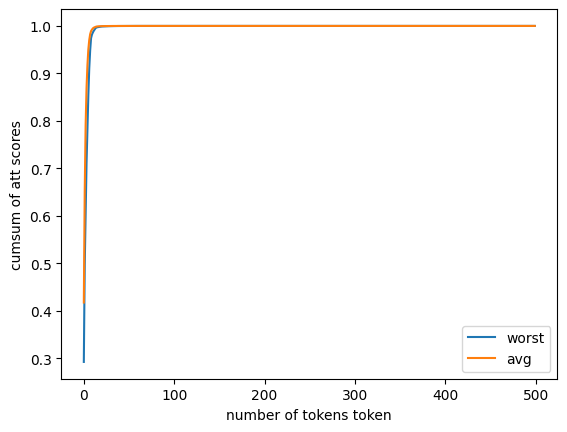

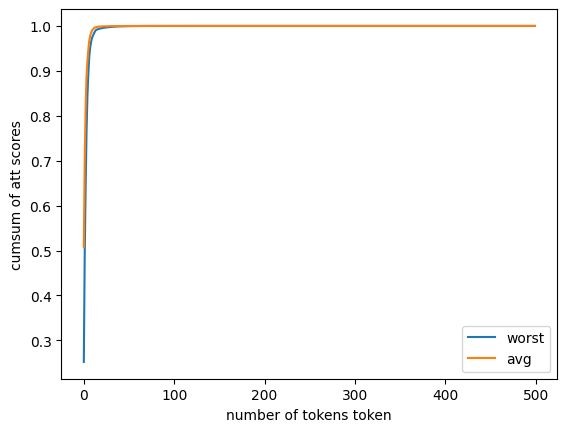

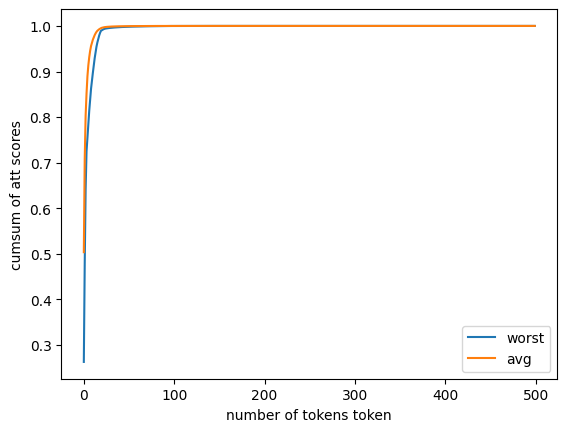

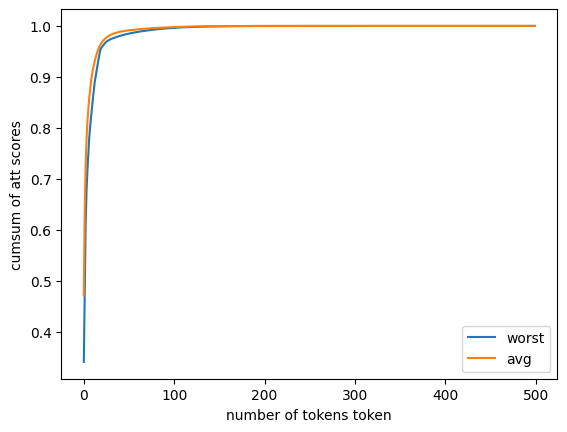

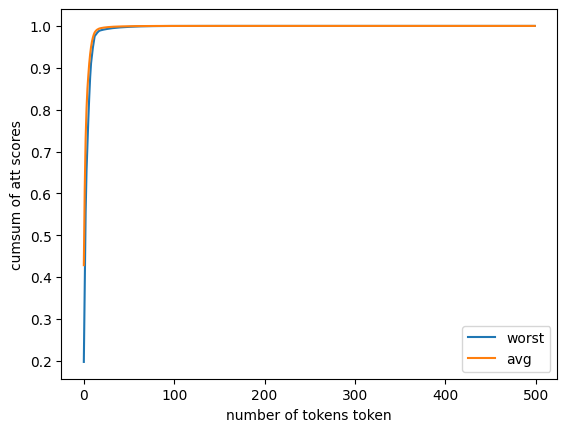

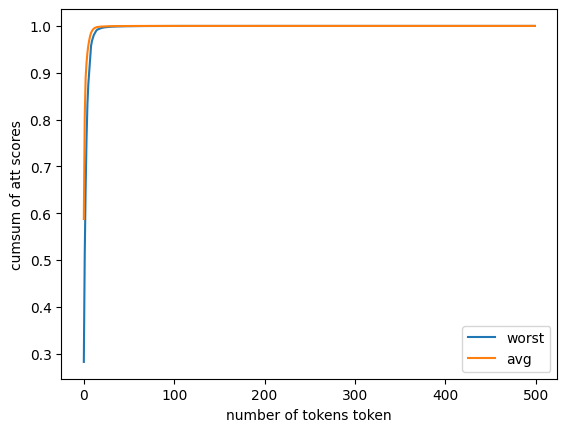

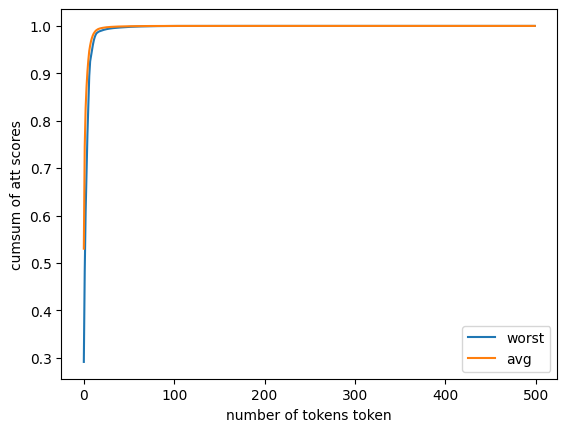

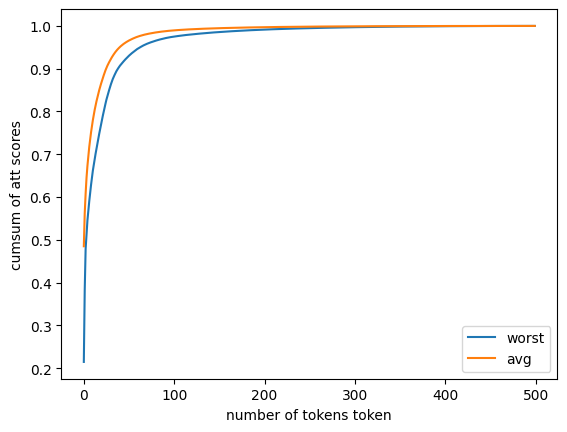

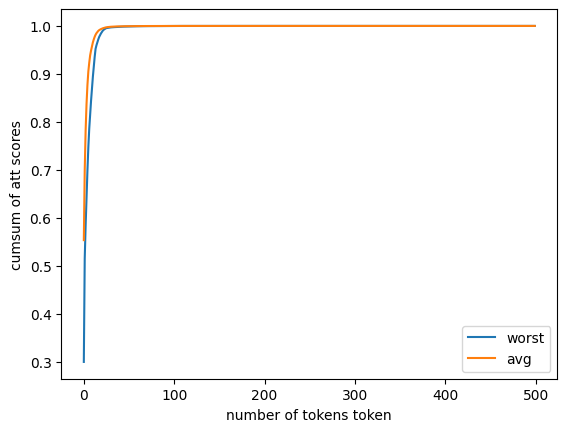

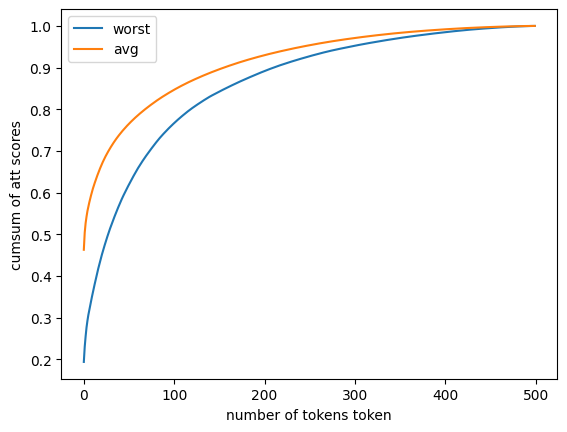

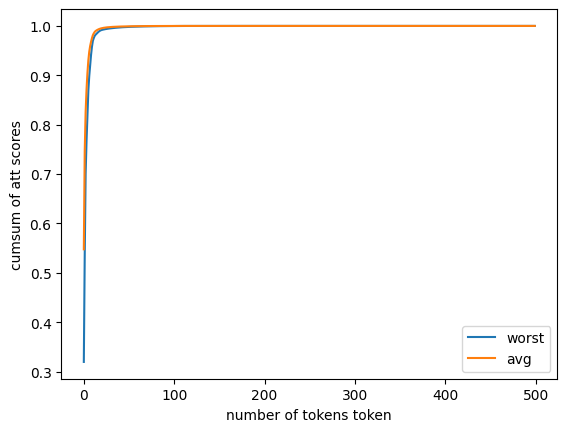

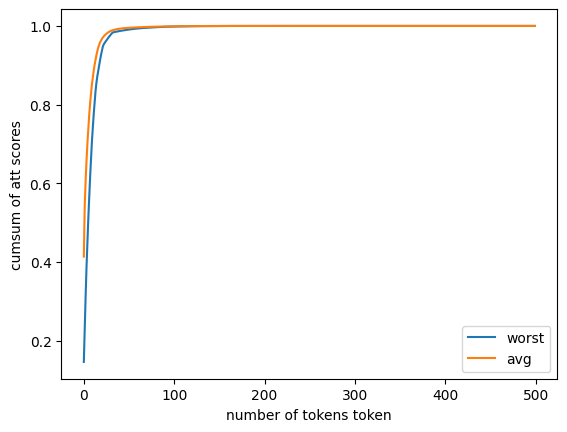

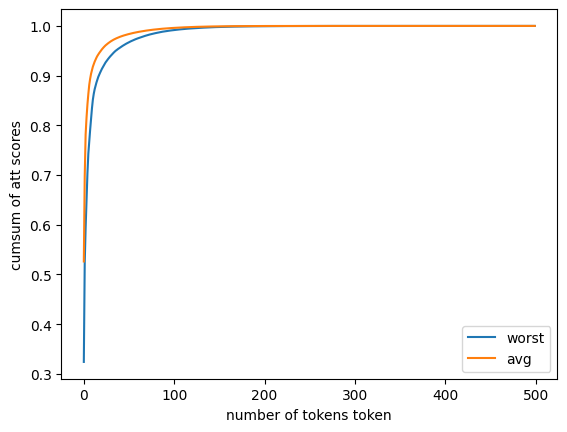

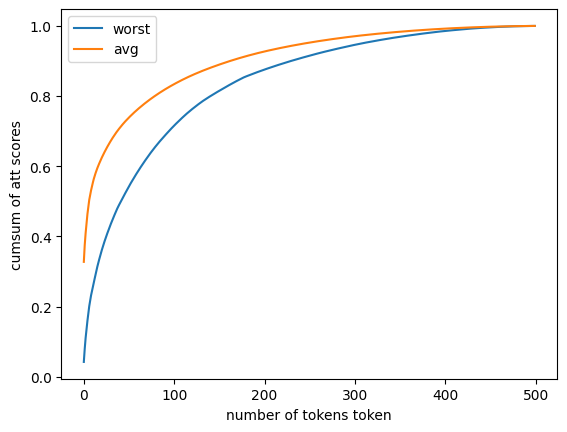

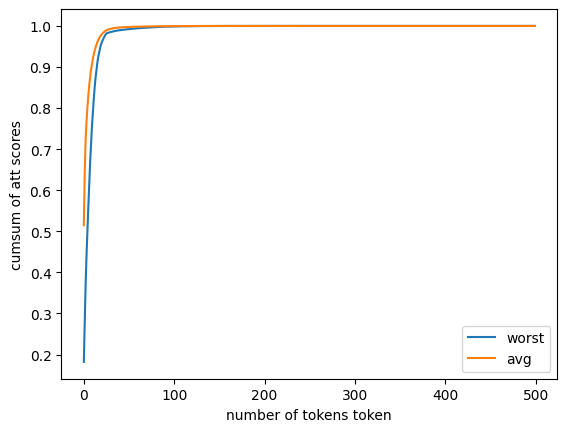

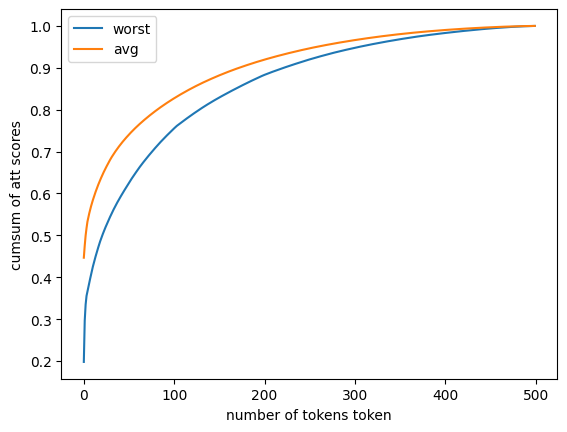

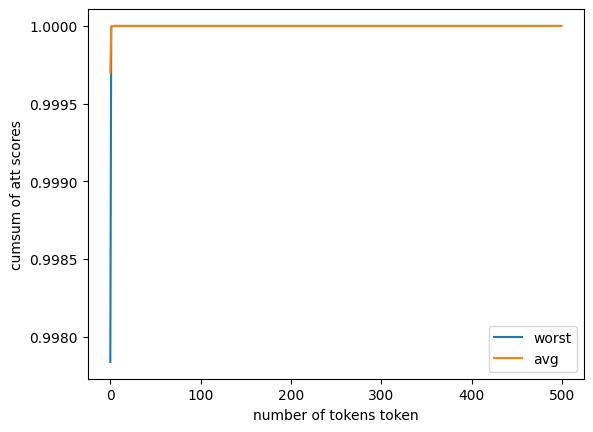

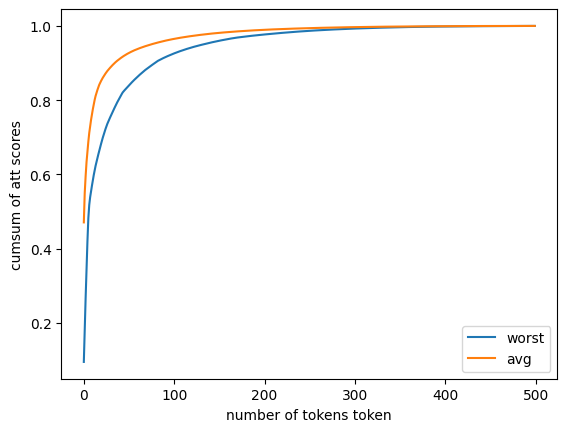

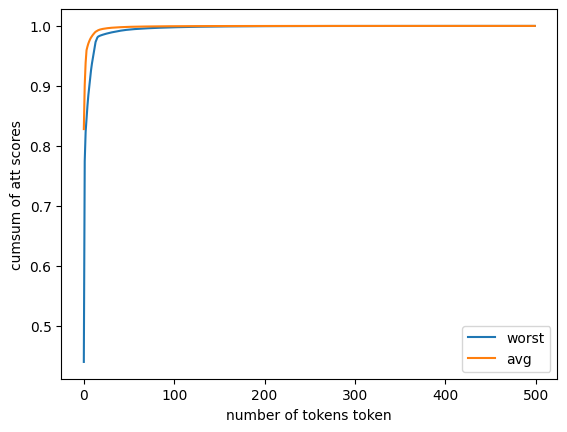

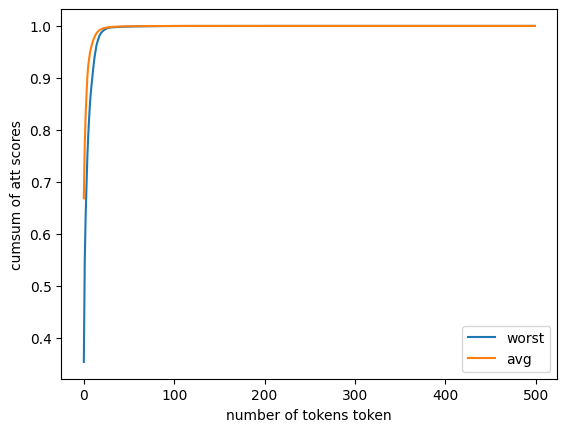

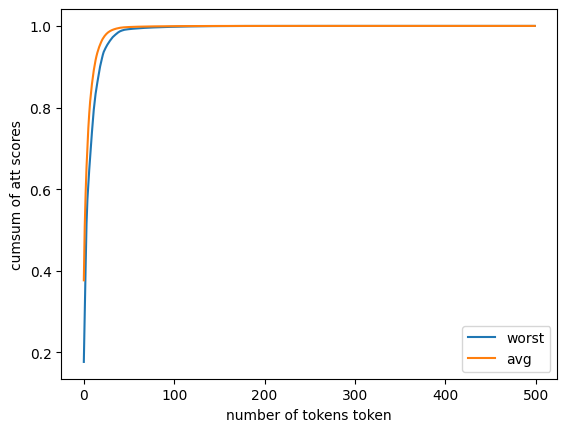

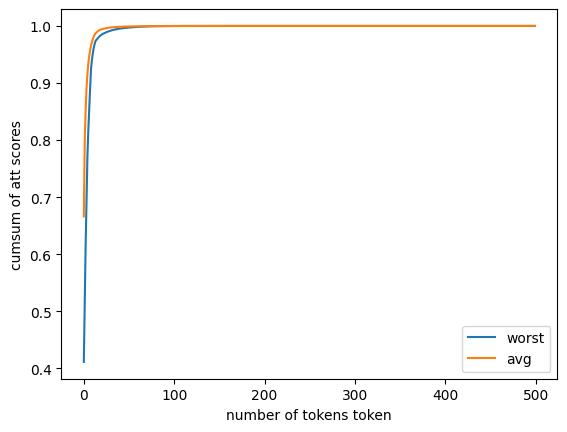

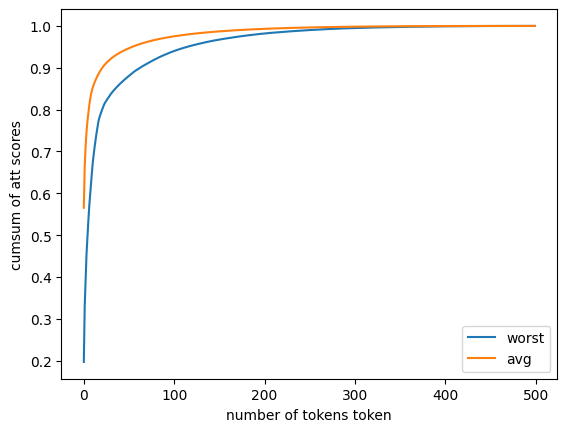

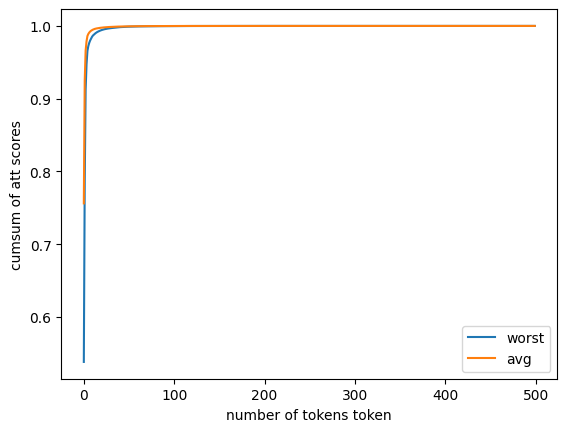

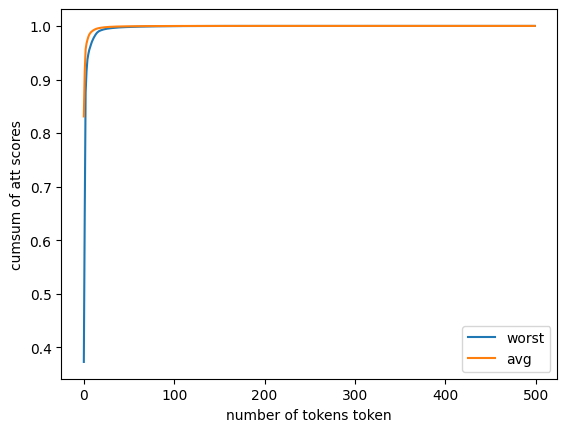

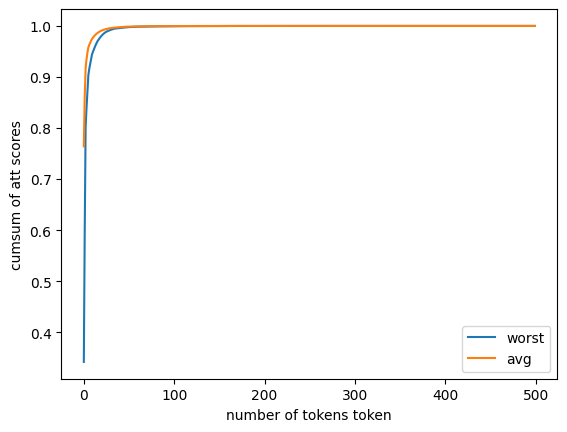

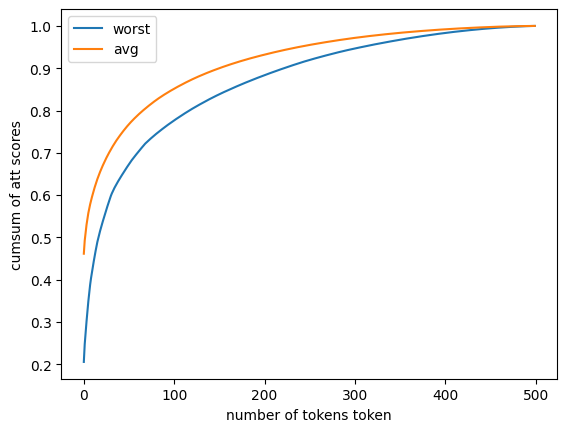

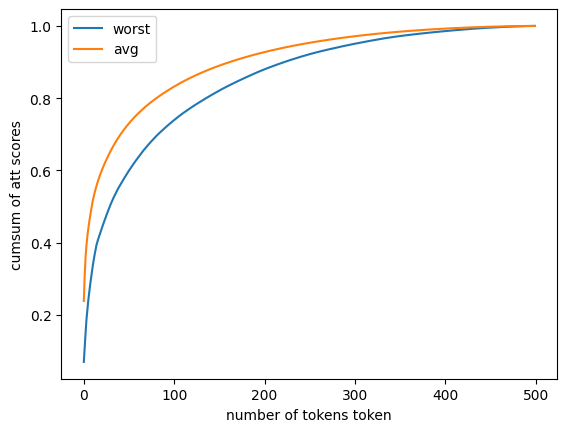

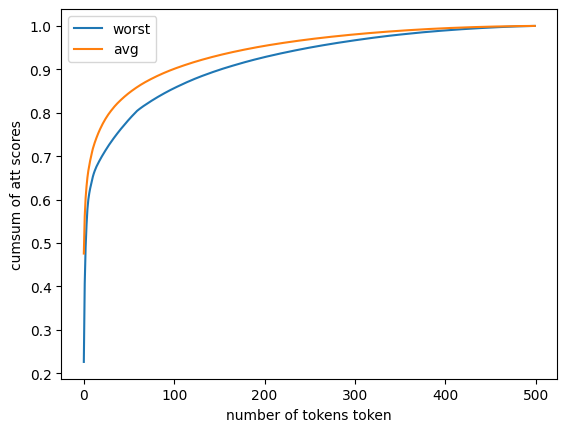

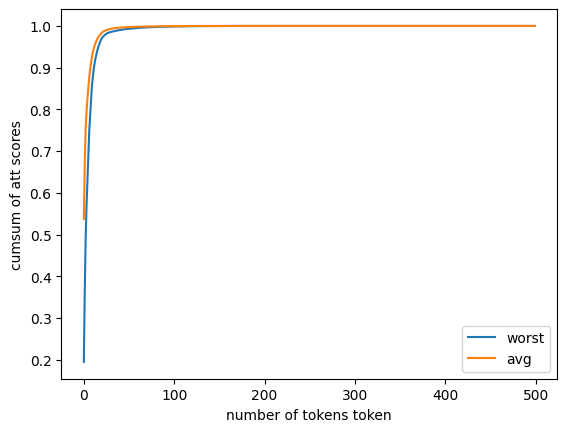

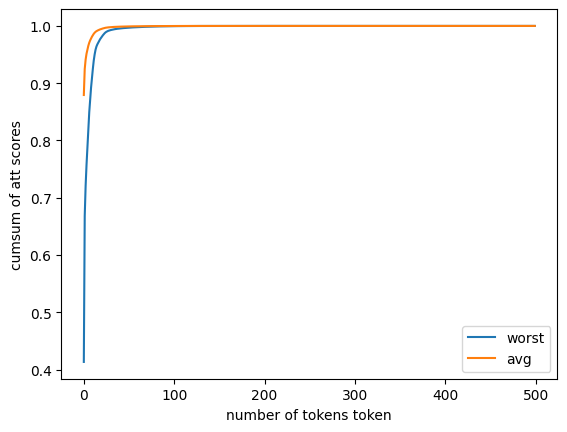

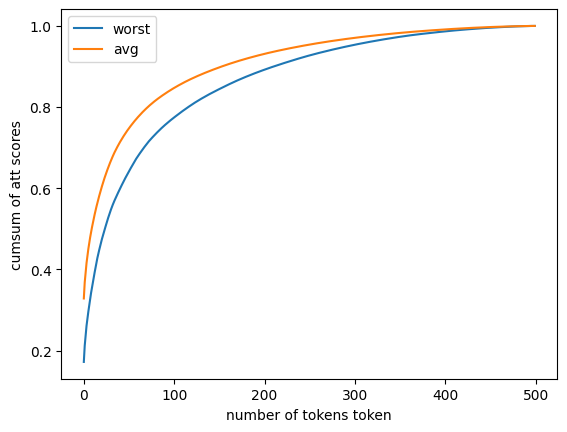

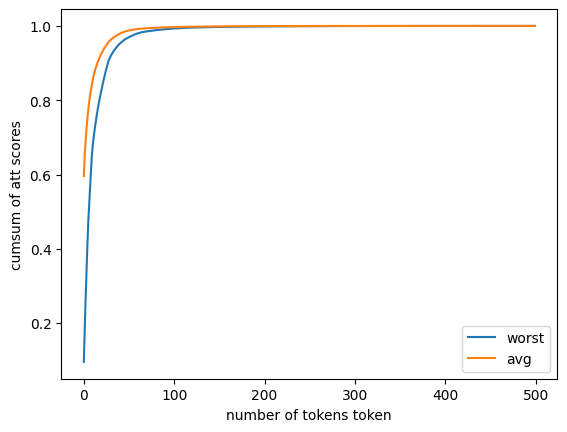

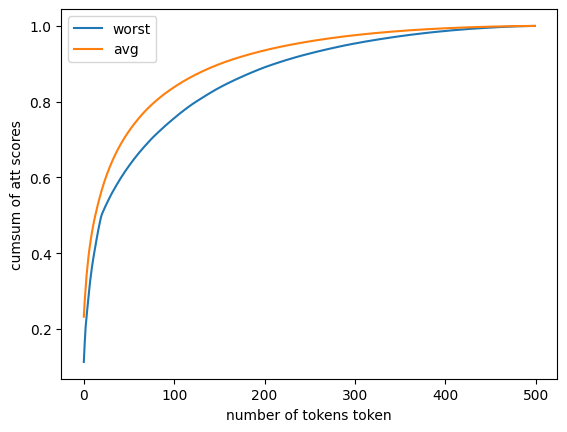

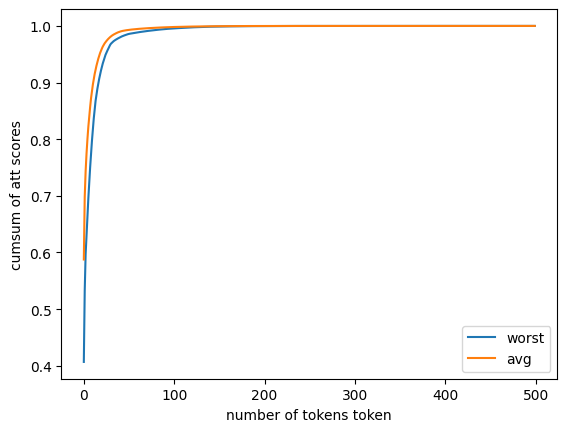

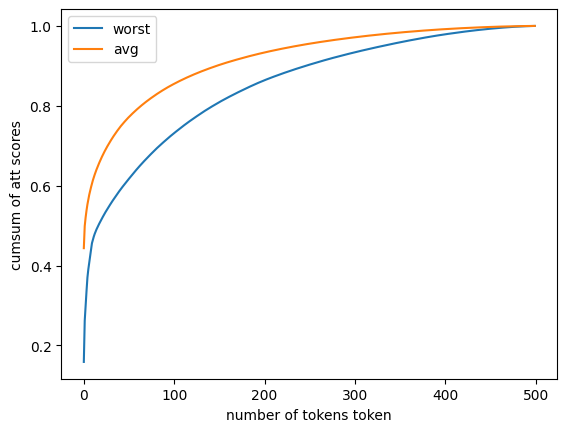

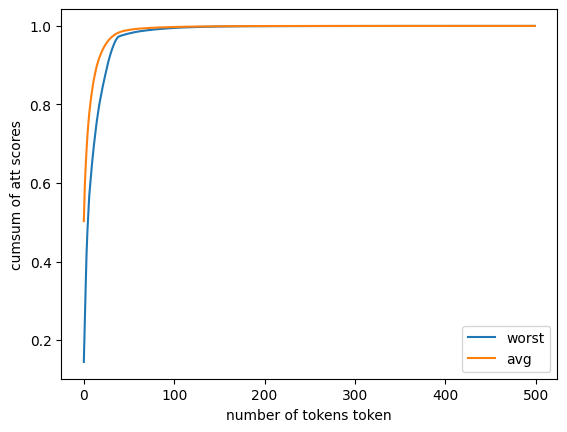

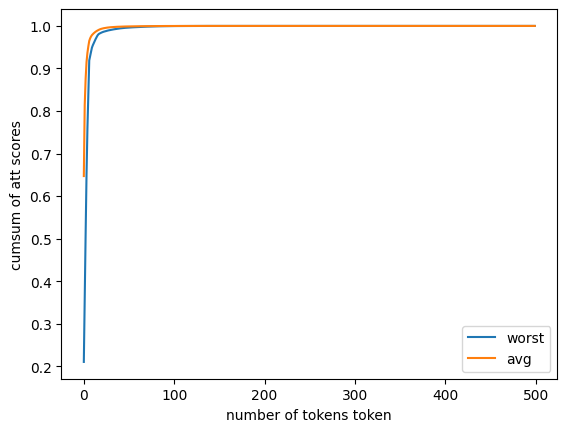

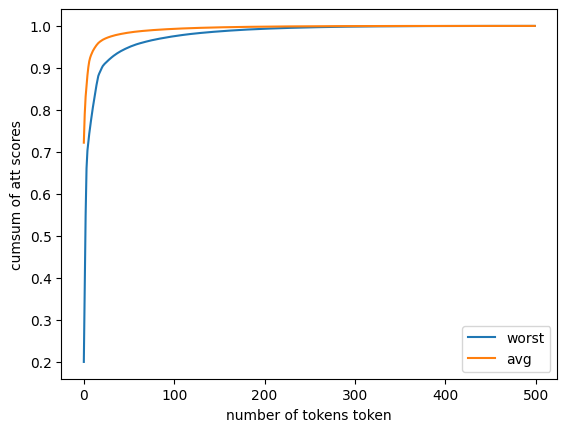

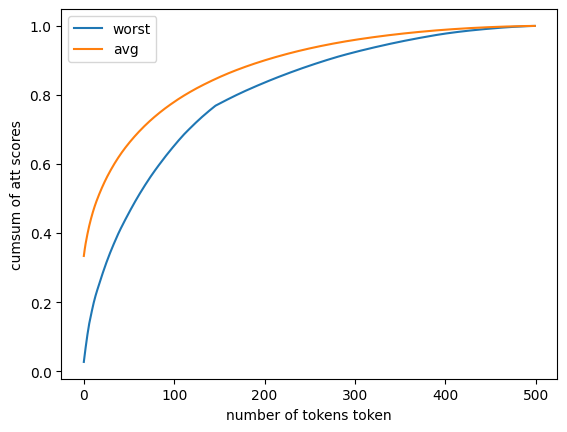

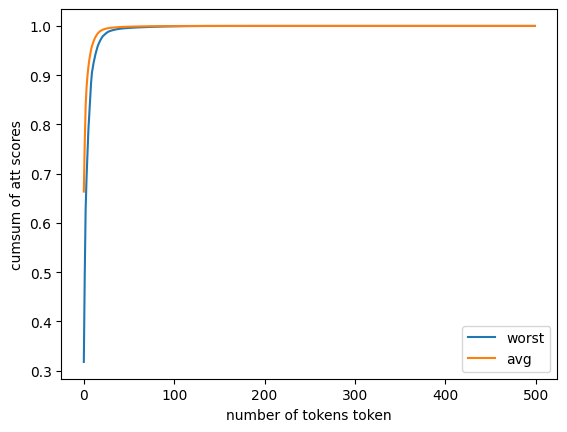

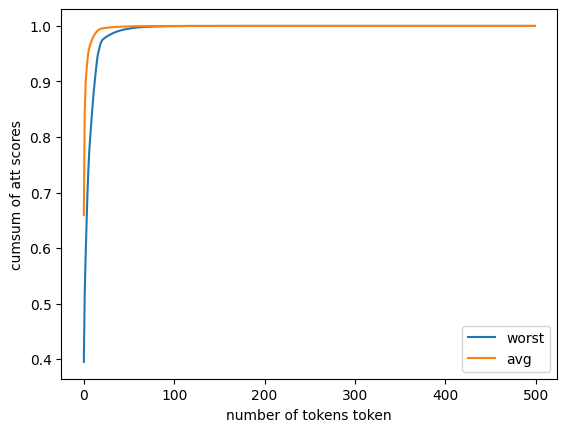

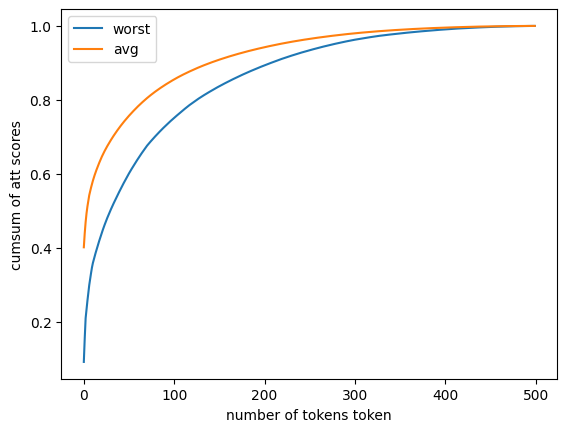

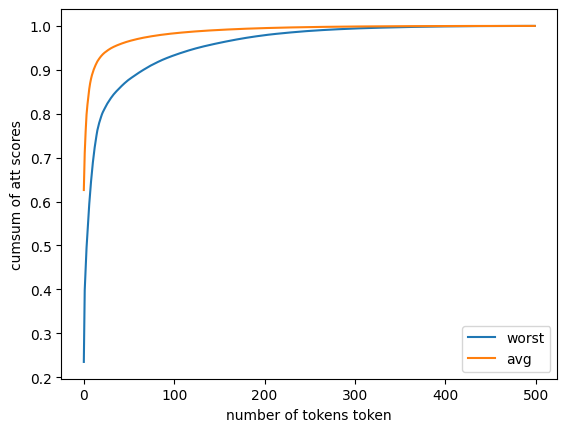

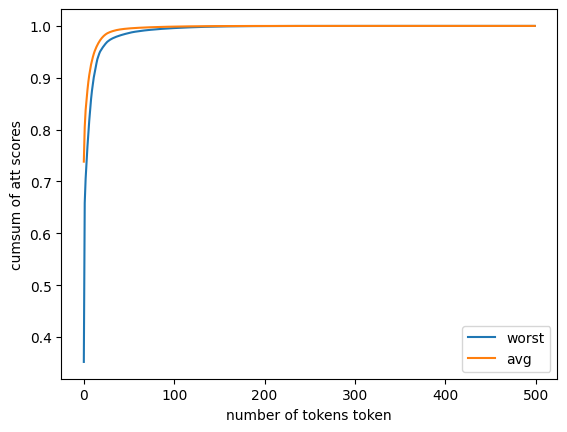

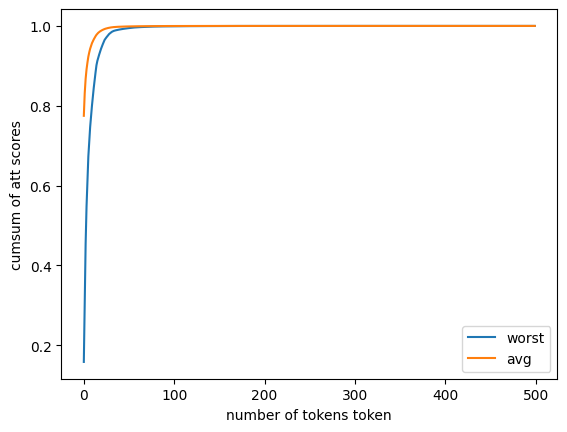

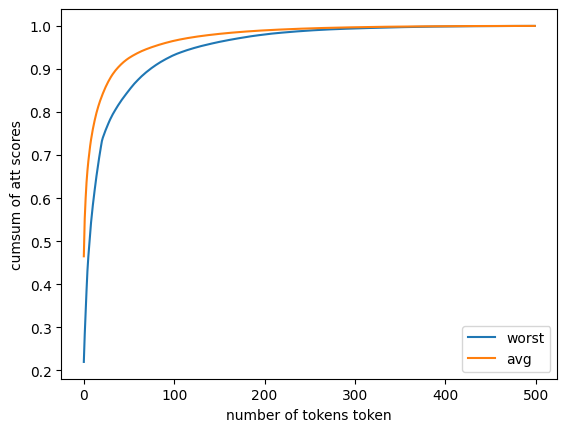

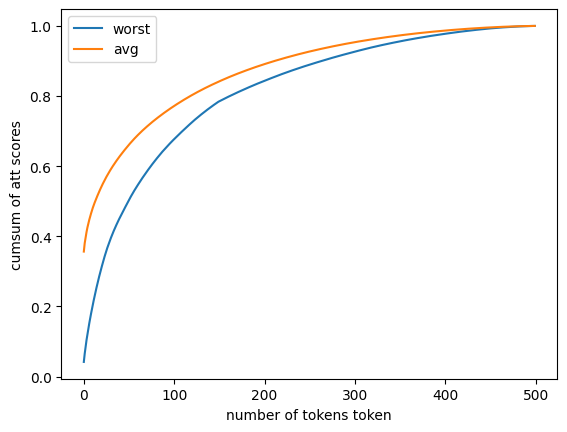

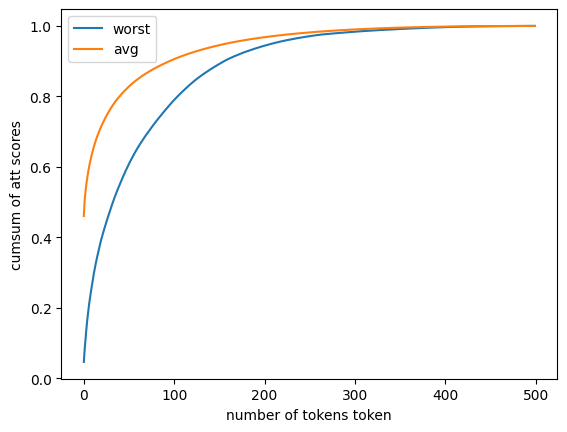

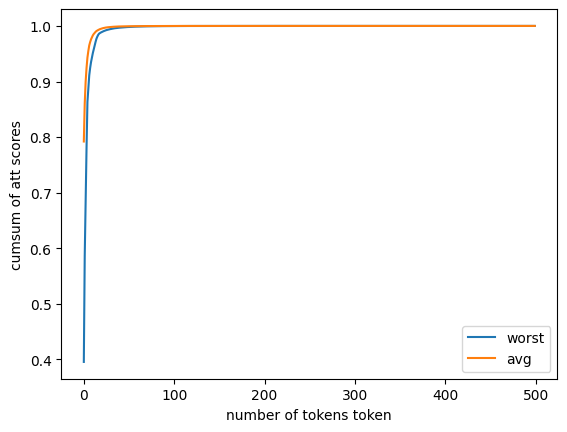

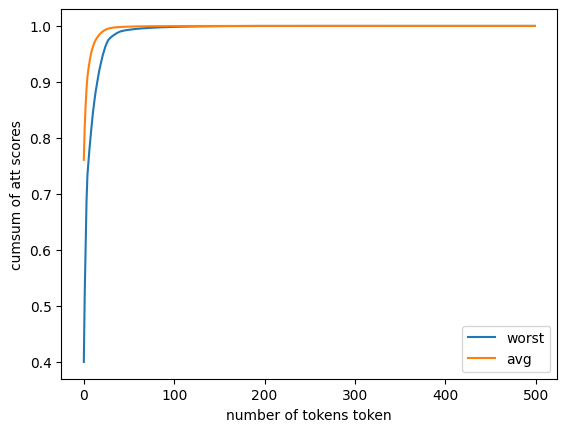

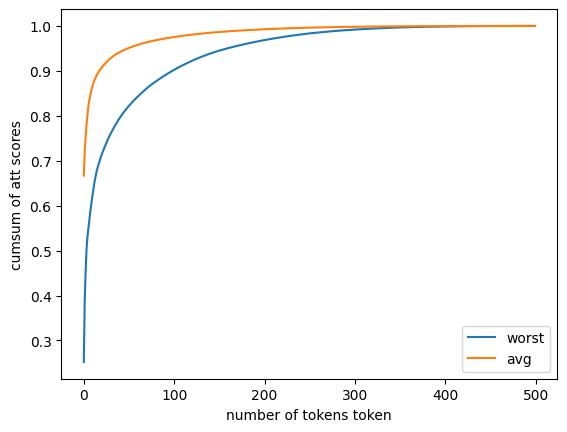

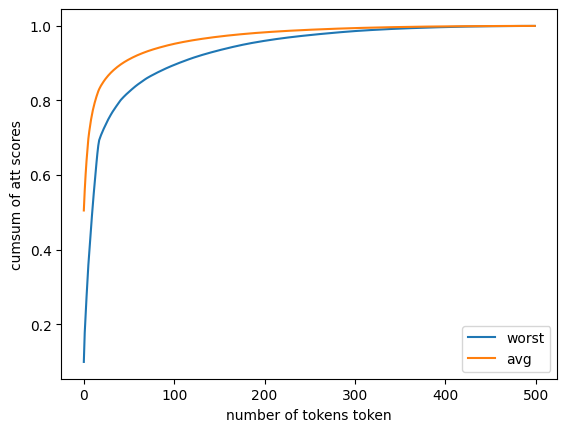

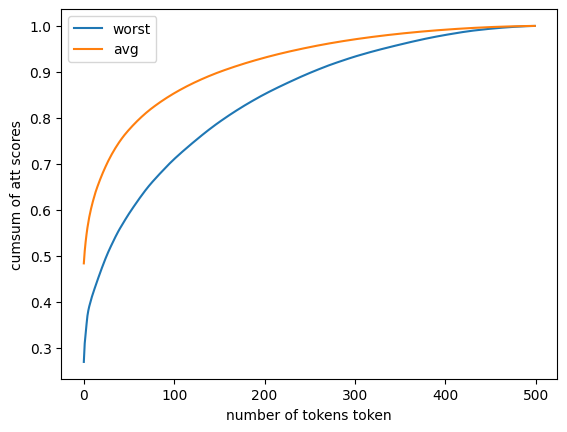

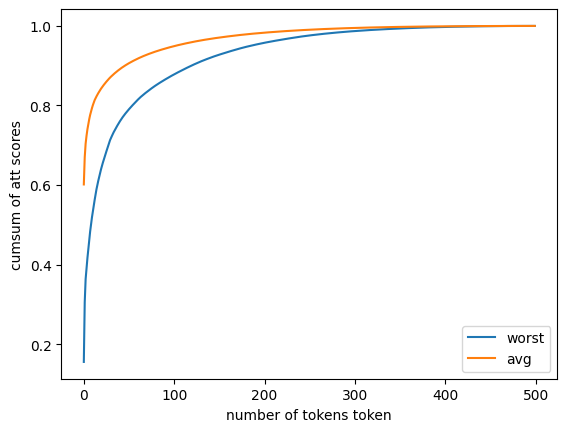

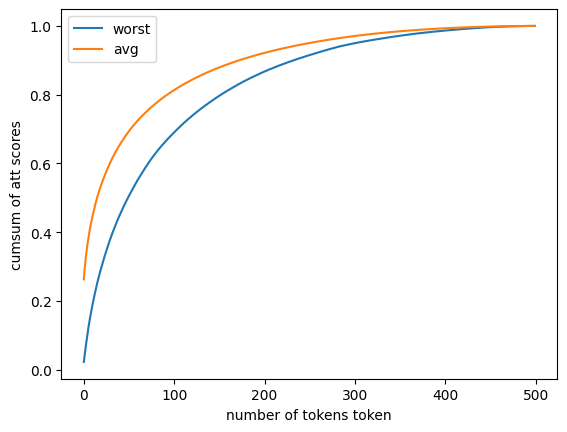

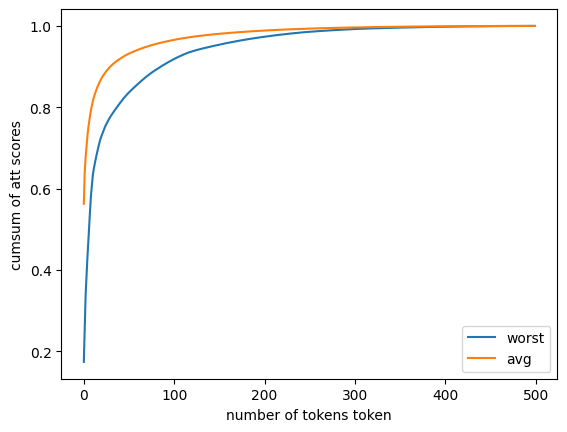

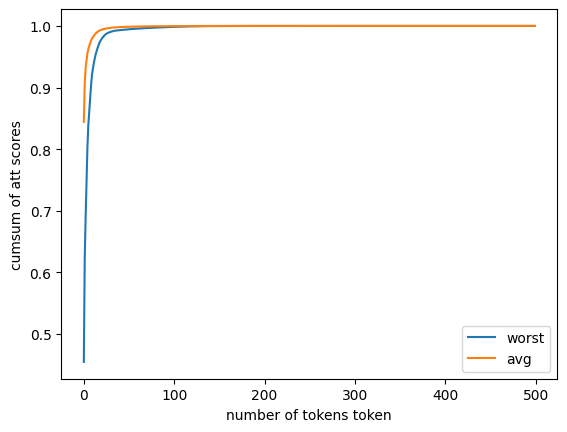

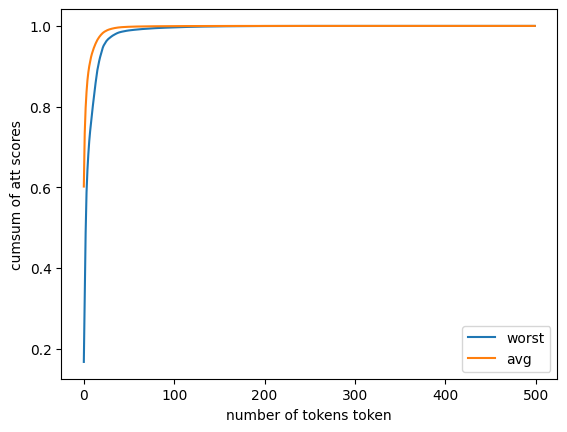

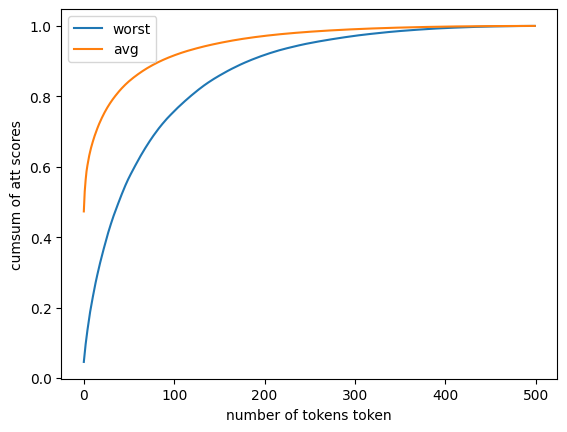

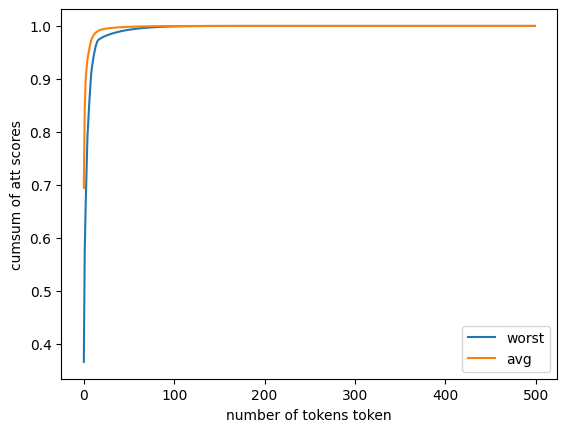

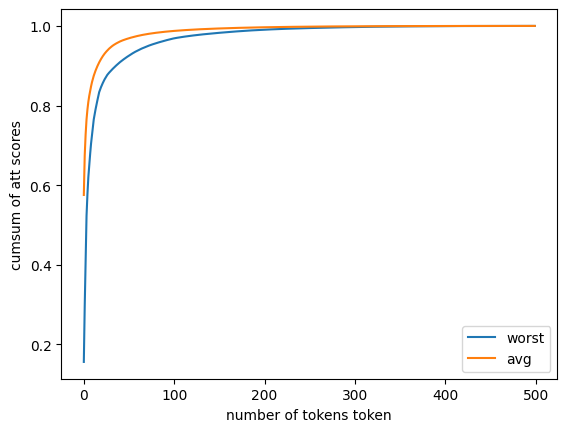

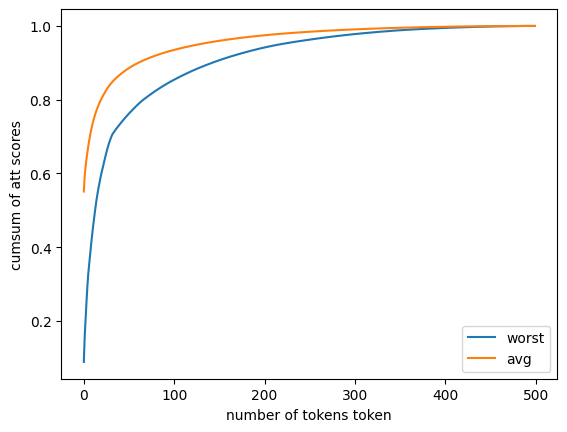

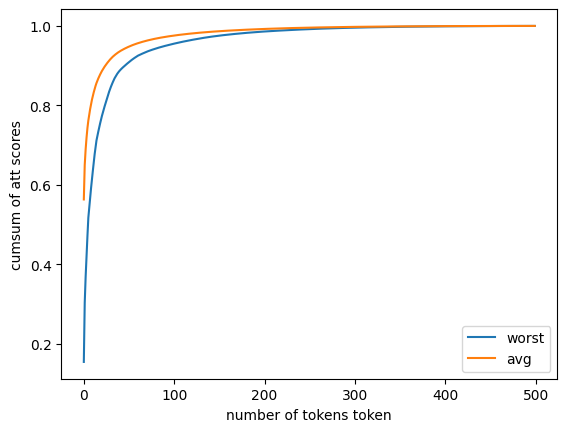

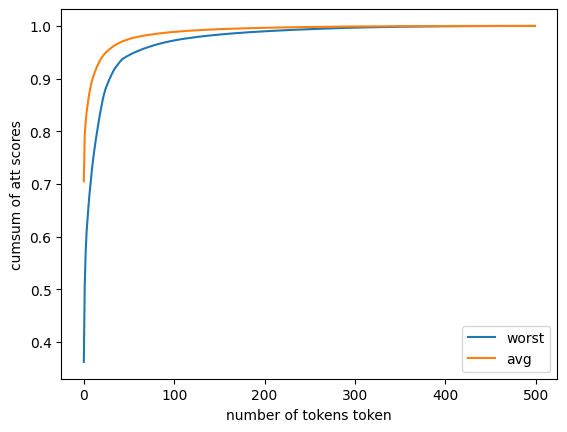

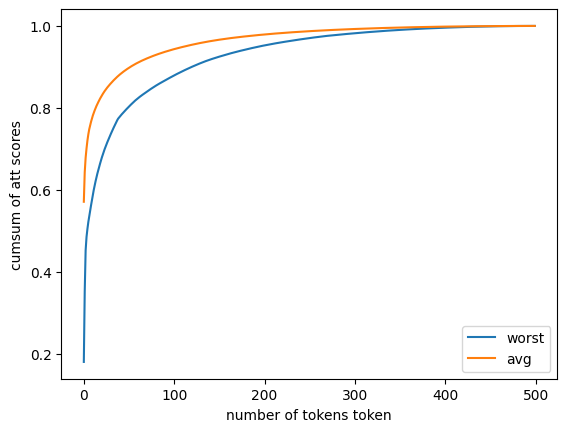

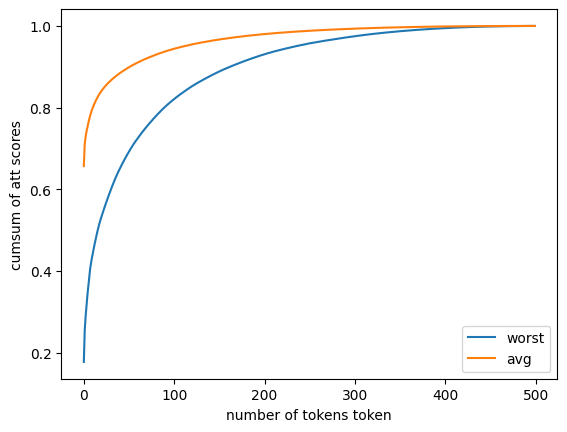

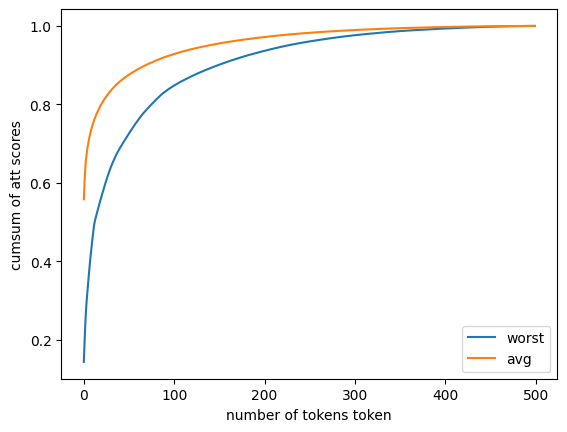

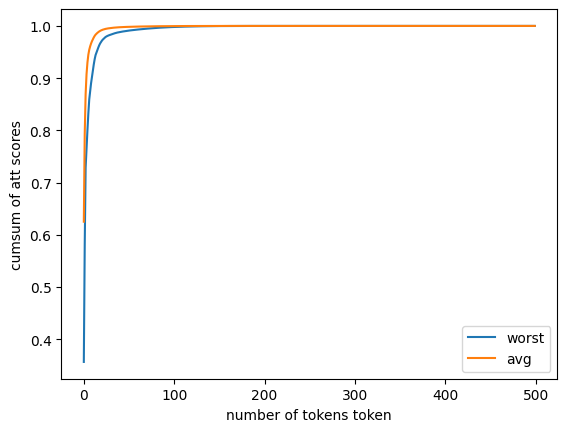

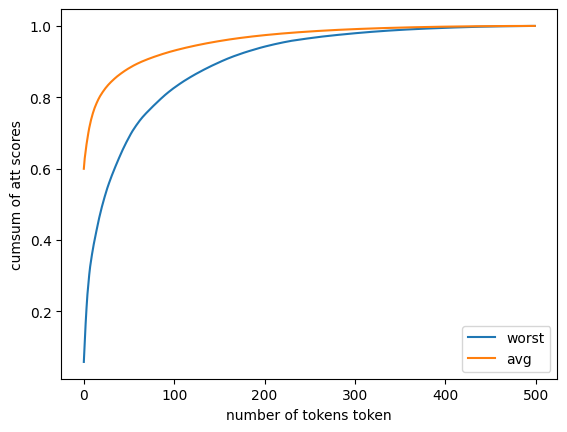

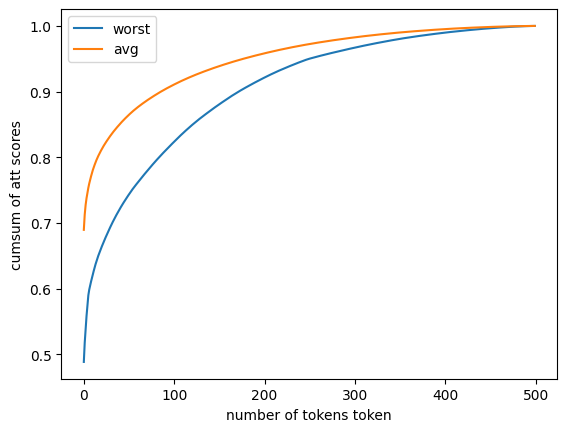

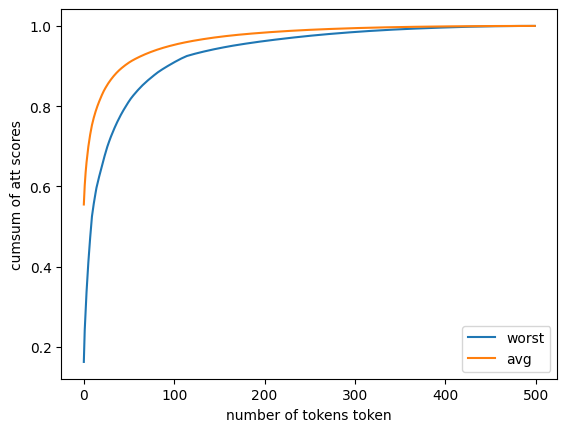

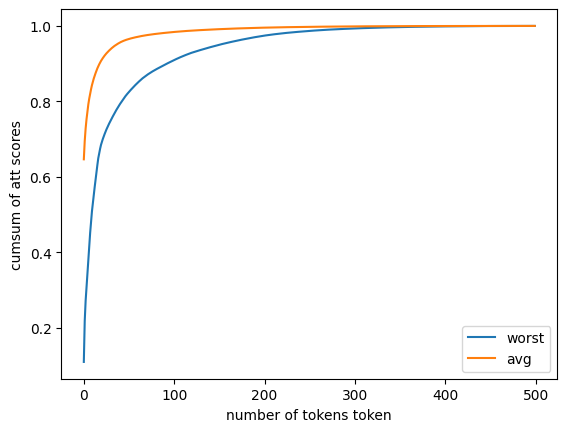

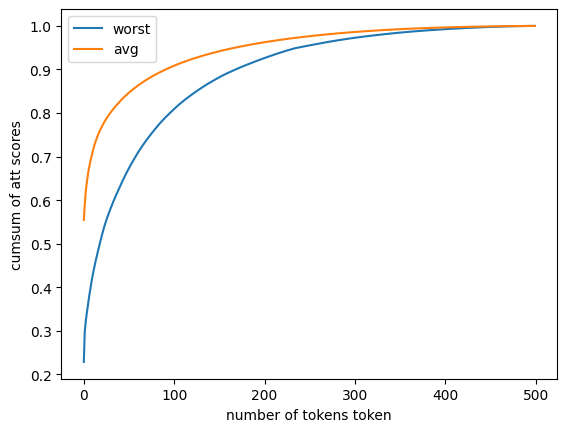

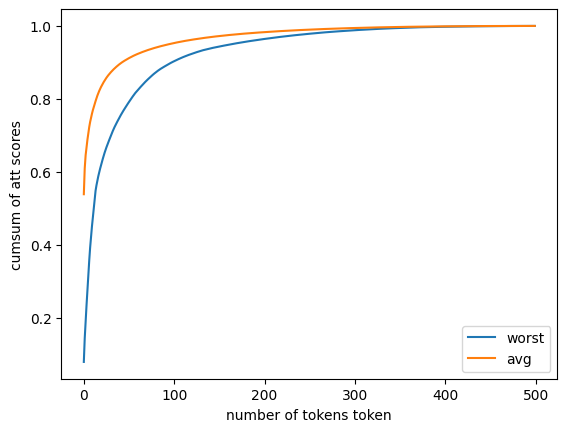

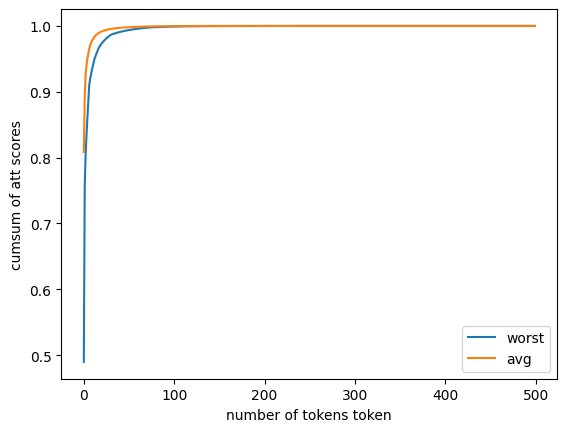

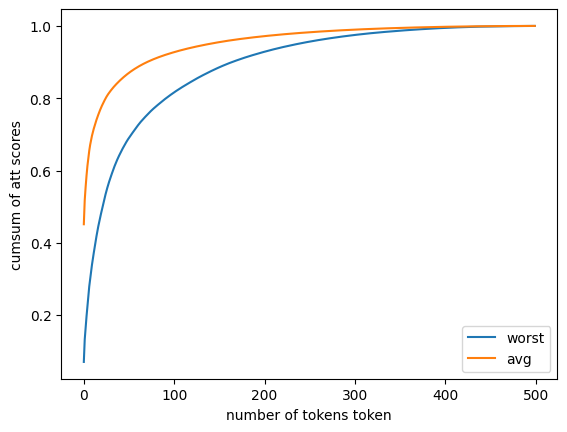

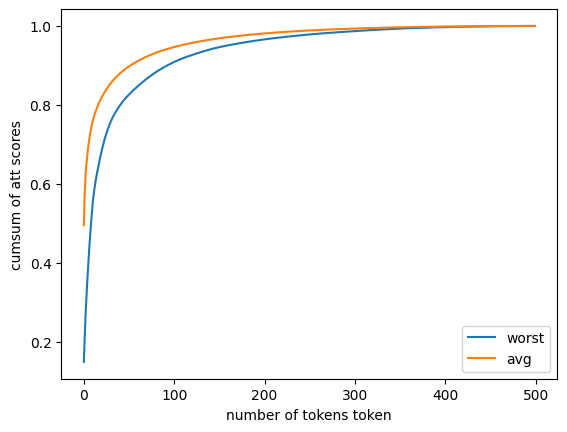

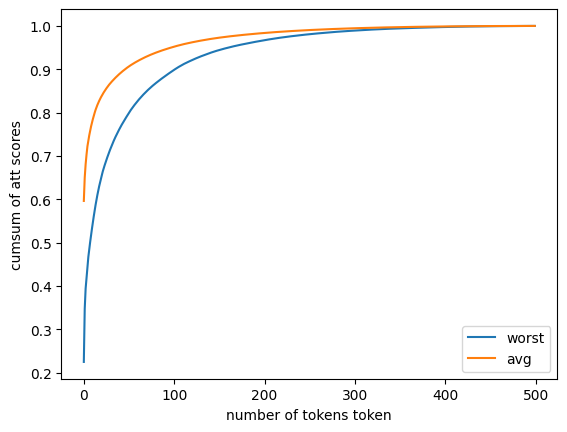

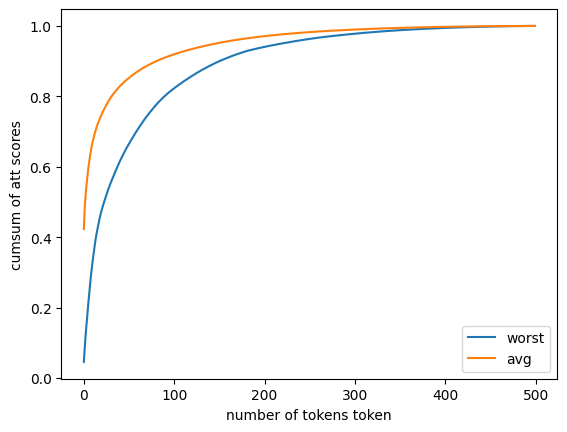

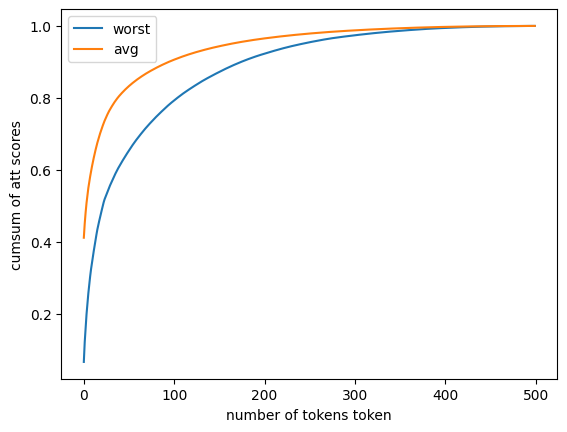

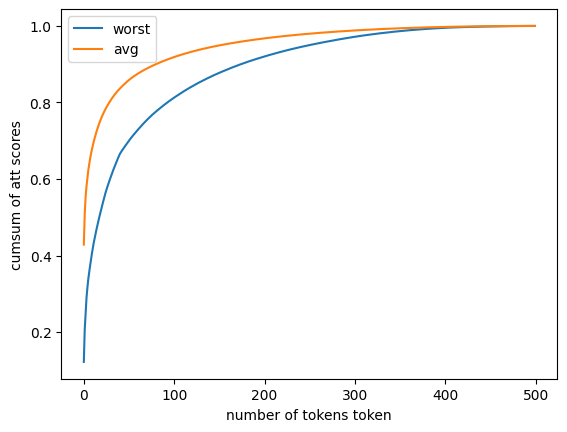

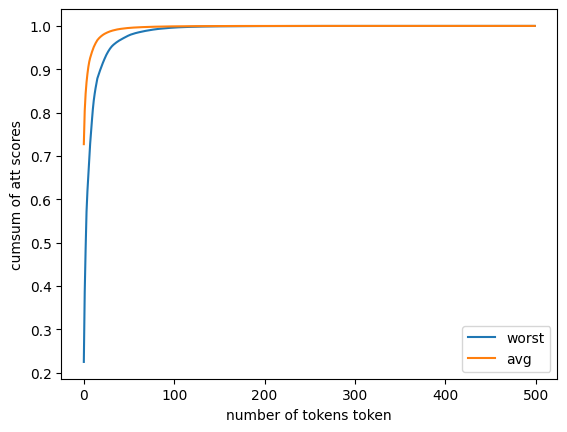

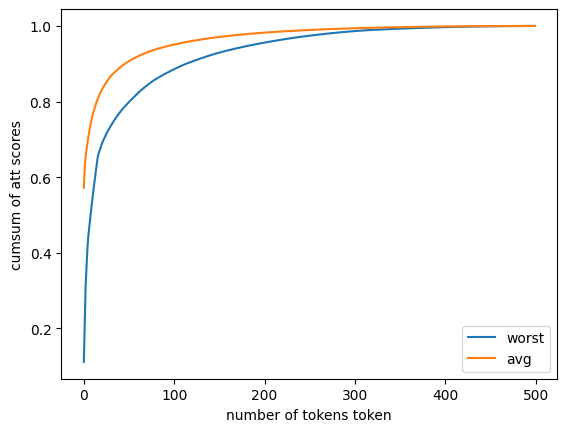

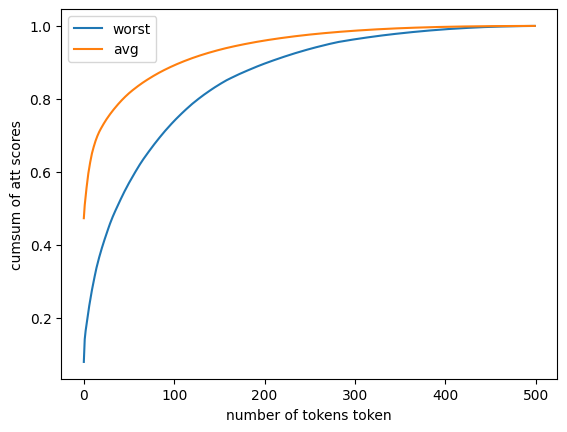

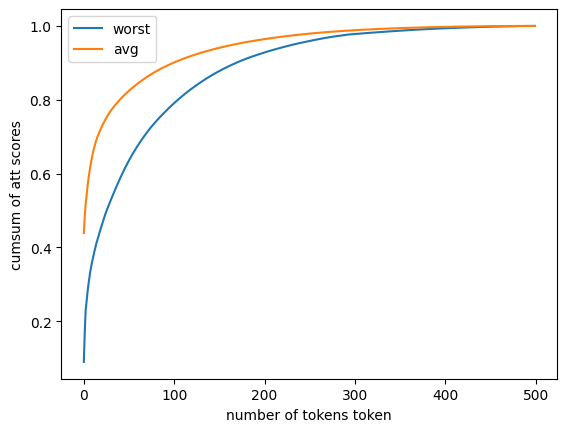

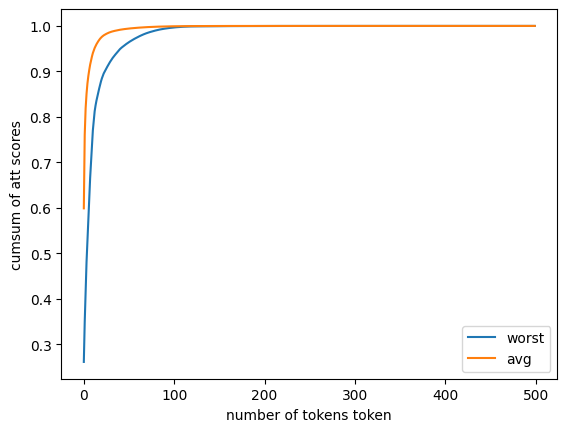

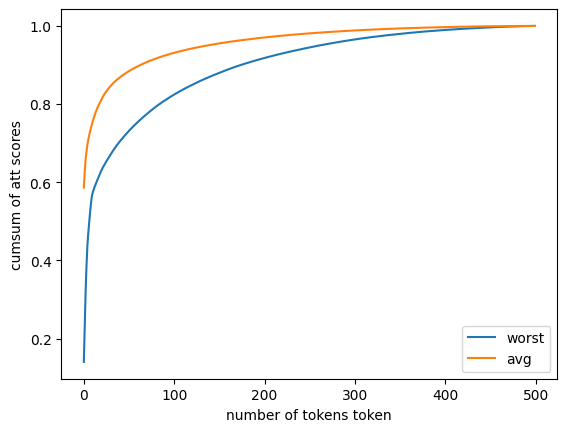

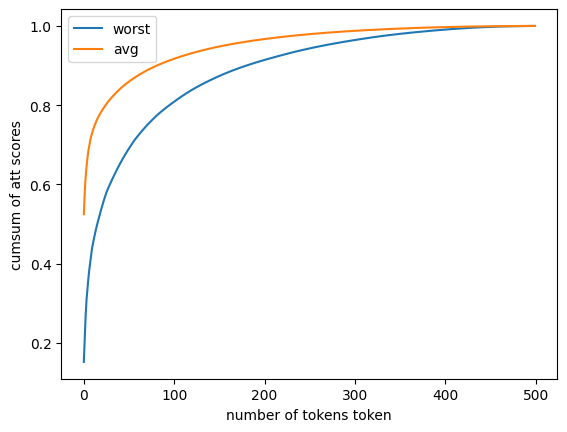

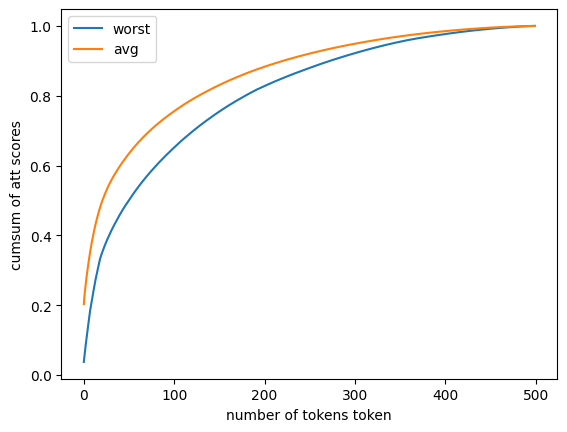

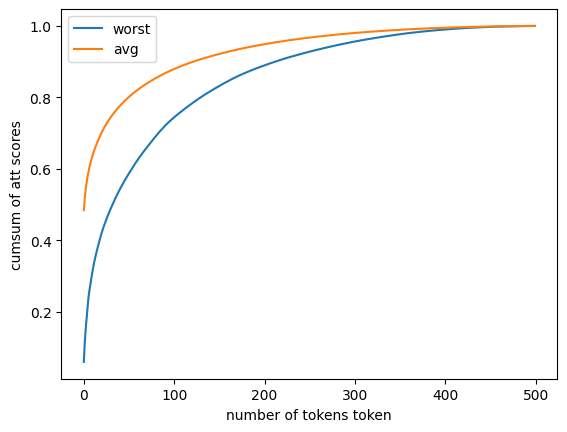

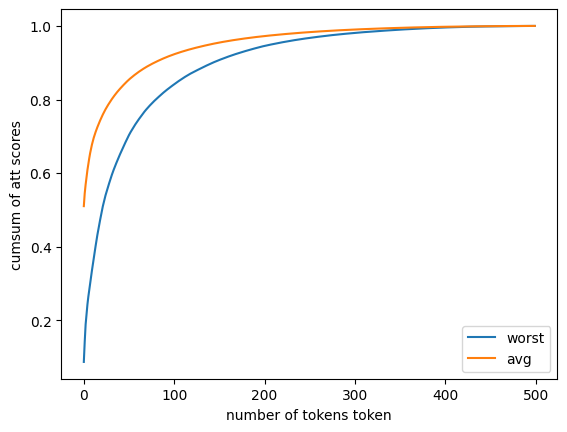

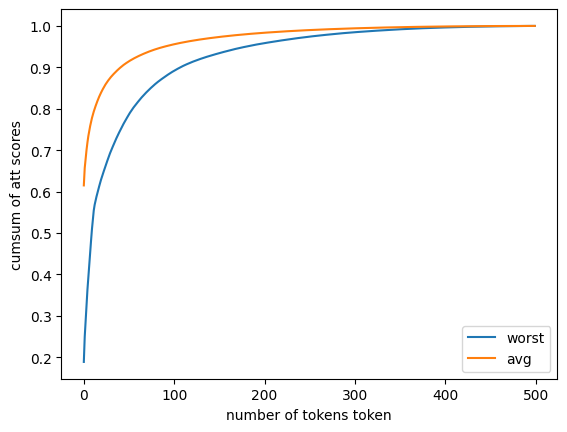

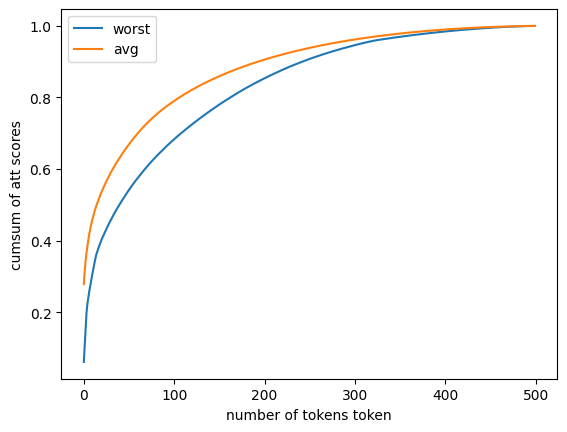

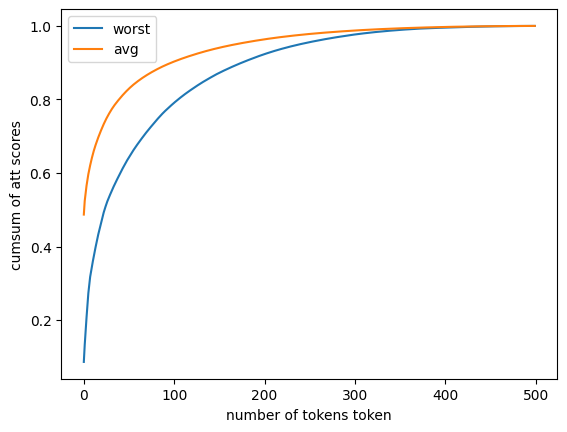

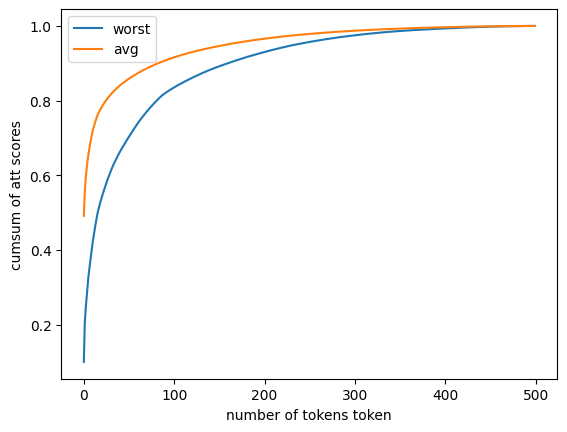

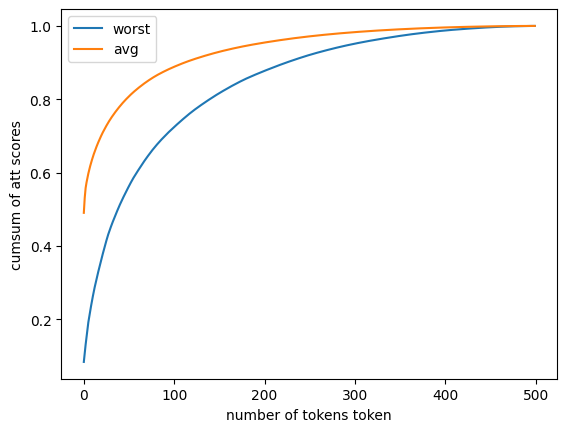

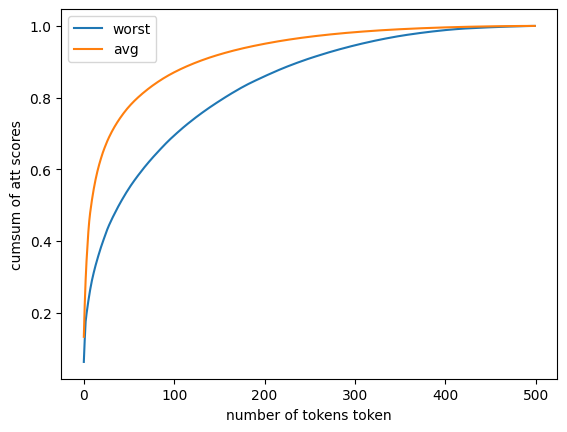

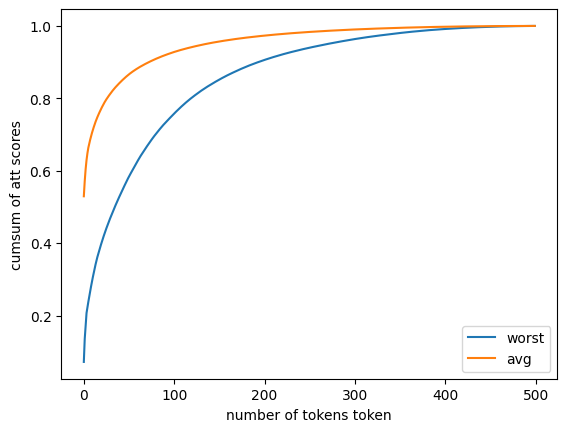

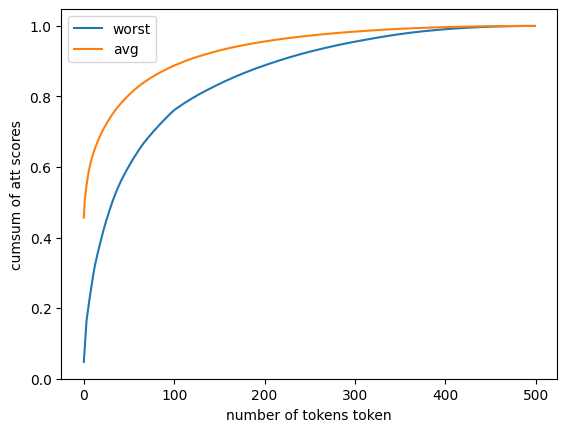

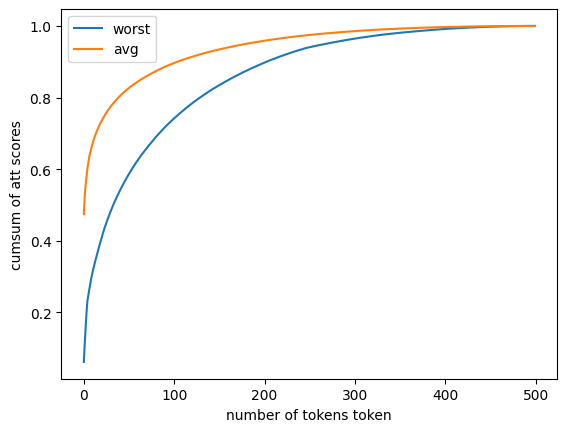

In [128]:
for l in range(model.config.n_layer):
    for h in range(model.config.n_head):
        plt.figure()
        plt.plot(cumsum_metrics[l][h]['worst'], label='worst')
        plt.plot(cumsum_metrics[l][h]['avg'] / num_of_samples, label='avg')
        plt.xlabel('number of tokens token')
        plt.ylabel('cumsum of att scores')
        plt.legend()


In [60]:
def analyze_cases(data):
    """
    Analyze the samples and return the average and worst case values for the top_percentile_prob and min_logits_for_cumsum metrics
    for each layer and head in the model.
    """
    # Initialize dictionaries to store the results
    top_percentile_prob_avg = defaultdict(lambda:defaultdict(lambda: defaultdict(lambda: 0.0)))
    top_percentile_prob_worst = defaultdict(lambda:defaultdict(lambda: defaultdict(lambda: 1.0)))
    min_logits_for_cumsum_avg = defaultdict(lambda:defaultdict(lambda: defaultdict(lambda: 0.0)))
    min_logits_for_cumsum_worst = defaultdict(lambda:defaultdict(lambda: defaultdict(lambda: 0.0)))

    # Iterate over each sample
    for sample in data:
        # Iterate over each layer in the sample
        for layer in sample:
            # Iterate over each head in the layer
            for head in sample[layer]:
                # Extract top_percentile_prob and min_logits_for_cumsum data
                top_percentile_prob_data = sample[layer][head]['top_percentile_prob']
                min_logits_for_cumsum_data = sample[layer][head]['min_logits_for_cumsum']

                # for each head, update the average and worst case values
                for key in top_percentile_prob_data:
                    top_percentile_prob_avg[layer][head][key] += top_percentile_prob_data[key]
                    top_percentile_prob_worst[layer][head][key] = min(top_percentile_prob_worst[layer][head][key], top_percentile_prob_data[key])

                for key in min_logits_for_cumsum_data:
                    min_logits_for_cumsum_avg[layer][head][key] += min_logits_for_cumsum_data[key]
                    min_logits_for_cumsum_worst[layer][head][key] = max(min_logits_for_cumsum_worst[layer][head][key], min_logits_for_cumsum_data[key])

    # Calculate the average values
    for layer in top_percentile_prob_avg:
        for head in top_percentile_prob_avg[layer]:
            for k1, k2 in zip(top_percentile_prob_avg[layer][head], min_logits_for_cumsum_avg[layer][head]):
                top_percentile_prob_avg[layer][head][k1] /= len(data)
                min_logits_for_cumsum_avg[layer][head][k2] /= len(data) 
            
    return top_percentile_prob_avg, top_percentile_prob_worst, min_logits_for_cumsum_avg, min_logits_for_cumsum_worst

In [61]:
top_percentile_prob_avg, top_percentile_prob_worst, min_logits_for_cumsum_avg, min_logits_for_cumsum_worst = analyze_cases(samples_metrics)

In [62]:
print(json.dumps(top_percentile_prob_avg[0][0], indent=4))
print(json.dumps(top_percentile_prob_worst[0][0], indent=4))
print(json.dumps(min_logits_for_cumsum_avg[0][0], indent=4))
print(json.dumps(min_logits_for_cumsum_worst[0][0], indent=4))


{
    "1%": 0.450539356470108,
    "5%": 0.7531849905848503,
    "10%": 0.8663284249603749,
    "20%": 0.9377491949126124
}
{
    "1%": 0.35742801427841187,
    "5%": 0.709641695022583,
    "10%": 0.8367023766040802,
    "20%": 0.9179209694266319
}
{
    "80%": 36.7,
    "90%": 75.1,
    "95%": 134.0,
    "99%": 289.6
}
{
    "80%": 43,
    "90%": 84,
    "95%": 152,
    "99%": 325
}


In [67]:
def plot_histograms(data_avg, data_worst, xlabel, title_template=None):
    # Collect all values for each percentile across all layers and heads
    percentiles = defaultdict(lambda: {'avg': [], 'worst': []})
    for layer in data_avg:
        for head in data_avg[layer]:
            for percentile in data_avg[layer][head]:
                percentiles[percentile]['avg'].append(data_avg[layer][head][percentile])
                percentiles[percentile]['worst'].append(data_worst[layer][head][percentile])

    print(json.dumps(percentiles, indent=4))
    
    # Plot histograms for each percentile
    for percentile in percentiles:
        plt.figure(figsize=(10, 5))
        plt.hist(percentiles[percentile]['avg'], bins=100, alpha=0.5, label='Average')
        plt.hist(percentiles[percentile]['worst'], bins=100, alpha=0.5, label='Worst')
        if title_template:
            plt.title(title_template.format(percentile))
        plt.xlabel(f'{xlabel} {percentile}')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()


{
    "1%": {
        "avg": [
            0.450539356470108,
            0.9887969577219338,
            0.223764967918396,
            0.9388662707060575,
            0.7641350060701371,
            0.977325860504061,
            0.2690368115901947,
            0.8833674352616072,
            0.4177432656288147,
            0.14434825778007507,
            0.1725652039051056,
            0.04576157331466675,
            0.7255555309355259,
            0.6843602269887924,
            0.07830381393432617,
            0.12122218608856201,
            0.25660310983657836,
            0.5271712243556976,
            0.28994445204734803,
            0.10737236142158509,
            0.12224740982055664,
            0.029293513298034667,
            0.160907644033432,
            0.42914660573005675,
            0.6091546893119812,
            0.19935349225997925,
            0.9792917395476252,
            0.829906065762043,
            0.8914119705557824,
            0.8958340883255005,
  

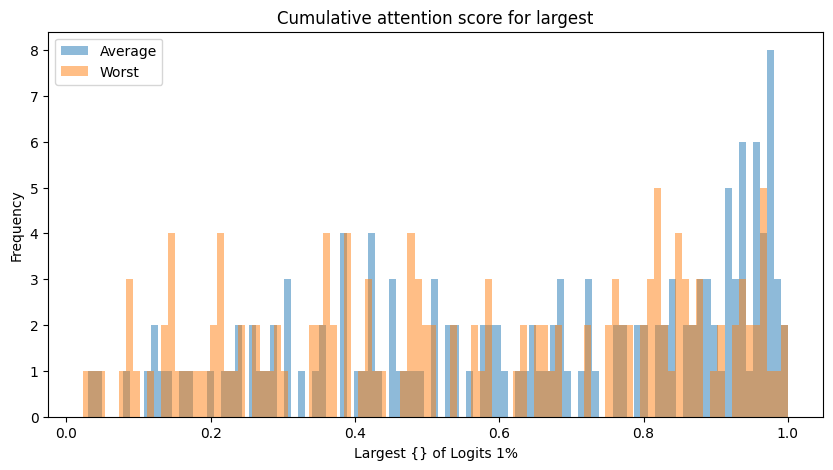

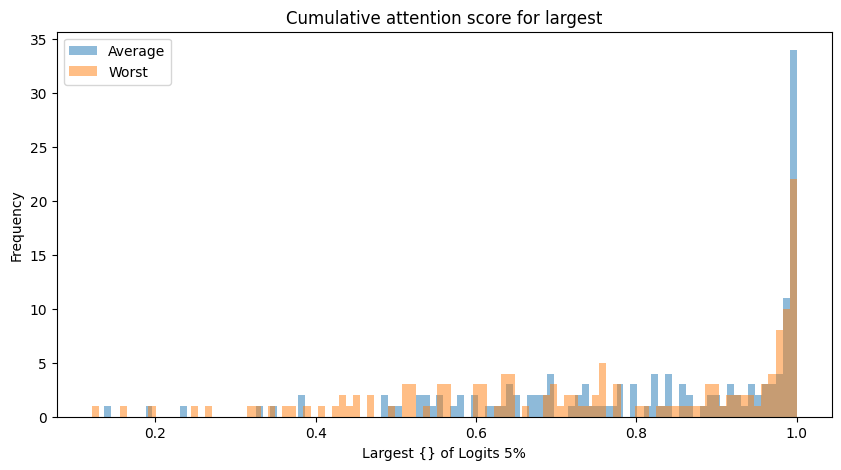

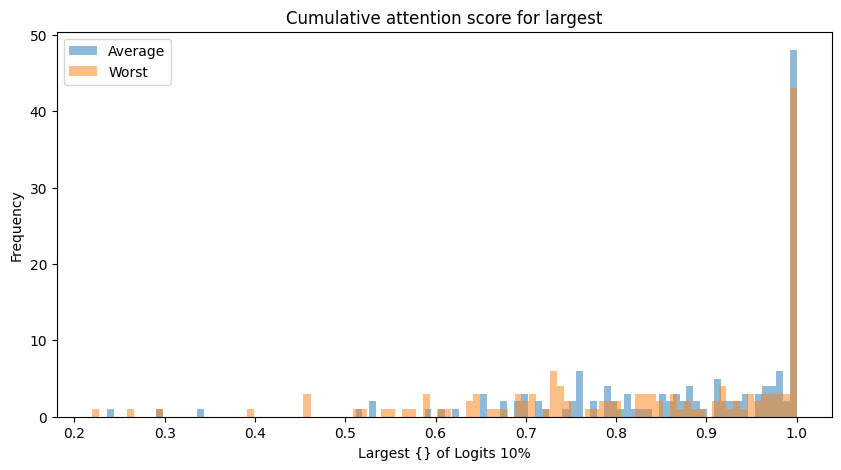

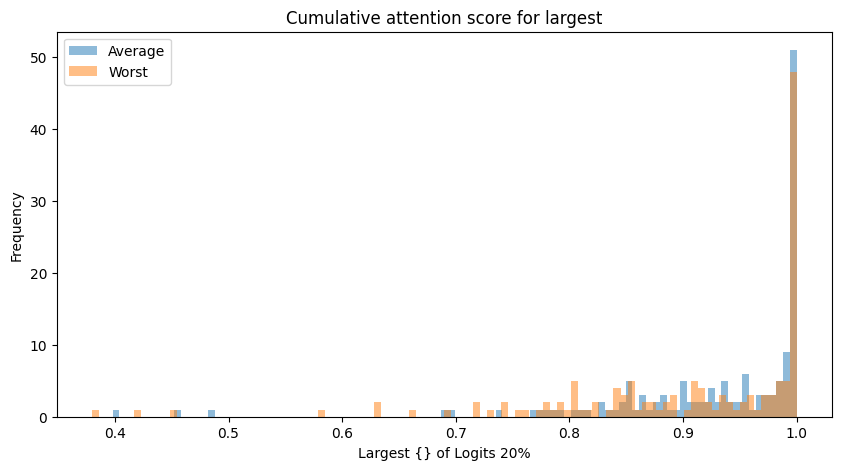

In [68]:
plot_histograms(top_percentile_prob_avg, top_percentile_prob_worst, 'Largest {} of Logits', 'Cumulative attention score for largest')


{
    "80%": {
        "avg": [
            36.7,
            1.0,
            82.9,
            2.5,
            5.6,
            1.0,
            57.4,
            3.7,
            32.6,
            83.0,
            58.9,
            314.7,
            9.3,
            10.5,
            115.3,
            99.6,
            30.8,
            62.1,
            66.8,
            183.6,
            322.3,
            351.5,
            87.9,
            76.3,
            11.8,
            98.4,
            2.5,
            4.5,
            3.7,
            3.4,
            13.4,
            26.3,
            4.4,
            5.1,
            24.7,
            43.1,
            58.6,
            5.5,
            3.0,
            1.3,
            101.6,
            22.4,
            3.3,
            4.7,
            3.5,
            2.4,
            8.3,
            3.5,
            2.7,
            2.6,
            12.6,
            2.7,
            131.1,
            1.1,
            9.

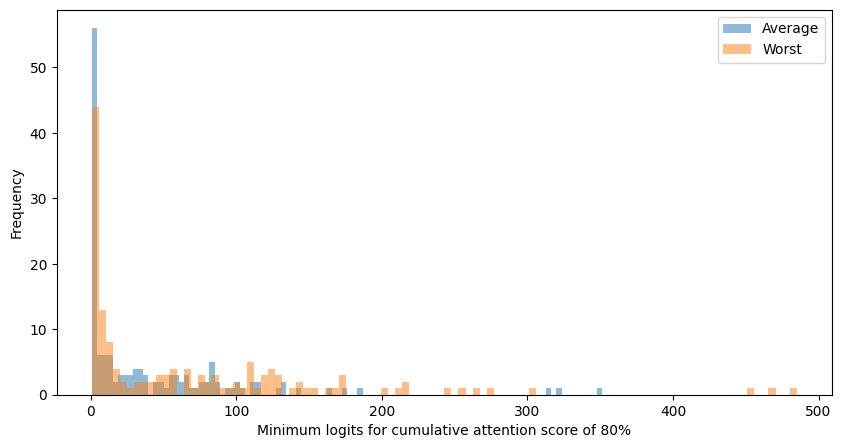

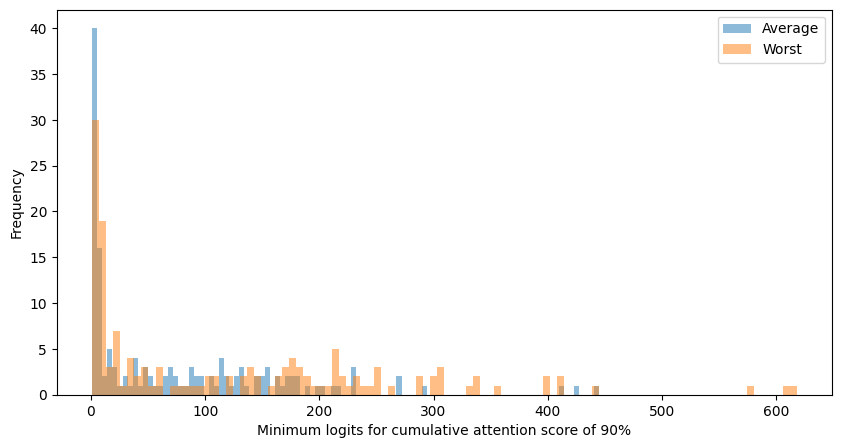

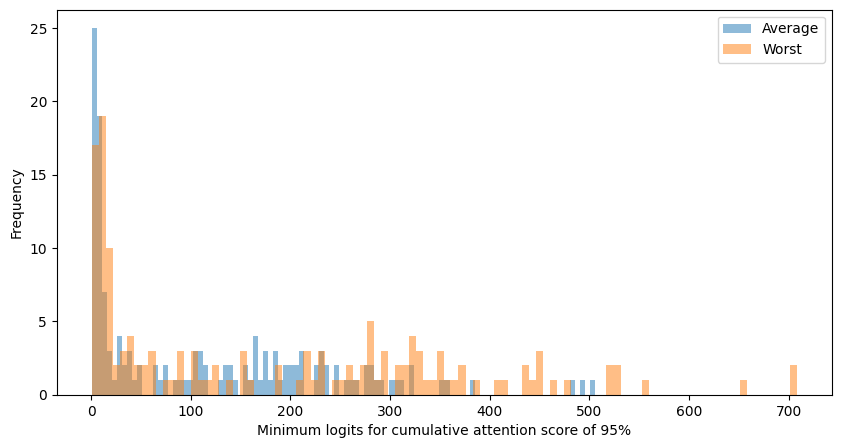

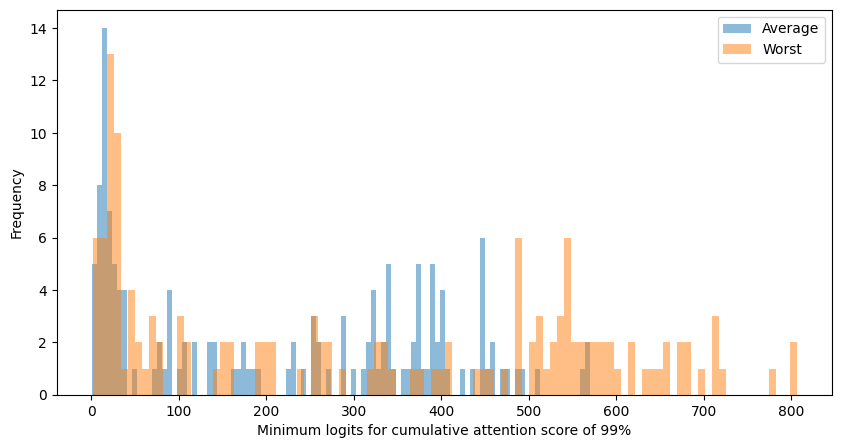

In [69]:
plot_histograms(min_logits_for_cumsum_avg, min_logits_for_cumsum_worst, 'Minimum logits for cumulative attention score of')

In [98]:
a = torch.zeros(5)
b = torch.randn(5)
a, b

(tensor([0., 0., 0., 0., 0.]),
 tensor([-0.5010,  0.2462, -1.1760,  0.0405, -0.2779]))

In [99]:
torch.min(a, b)

tensor([-0.5010,  0.0000, -1.1760,  0.0000, -0.2779])